In [1]:
%matplotlib inline
import sys
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde

In [2]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%autoreload 2
# importing plotting and locus tools: 
sys.path.append('../src')
sys.path.append('../paper/notebooks')
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt
import paperPlots as pp

## read Stripe 82 SDSS-Gaia data for plots...   

In [3]:
datafile = '../data/Stripe82GaiaEDR3.csv'
s82gaia = Table.read(datafile) 
# reddening corrected SDSS colors
df = s82gaia
df['Ar'] = df['AR_val']
C = lt.extcoeff()
for b in ['u', 'g', 'i', 'z']:  
    df['A'+b] = C[b]*df['Ar']  
# and now apply reddening corrections
df['ug'] = df['u_mMed'] - df['g_mMed'] - (df['Au']-df['Ag'])
df['gr'] = df['g_mMed'] - df['r_mMed'] - (df['Ag']-df['Ar'])
df['ri'] = df['r_mMed'] - df['i_mMed'] - (df['Ar']-df['Ai'])
df['iz'] = df['i_mMed'] - df['z_mMed'] - (df['Ai']-df['Az'])
df['gi'] = df['gr'] + df['ri'] 
df['rmag'] = df['r_mMed']
# for plots, wrapped RA
ra = df['ra_gaia'] 
df['raW'] = np.where(ra > 180, ra-360, ra)

In [4]:
## a few subsamples for plots
# u flux limit (and r band - but just one source rejected)
rMax = 22.0
uMin = 12.0 
uMax = 22.0 
flag = (s82gaia['r_mMed']<rMax)&(s82gaia['u_mMed']>uMin)&(s82gaia['u_mMed']<uMax) 
s82gaiaB = s82gaia[flag]
# for fitting MS and giants
flag = (s82gaiaB['gi']>0.2)&(s82gaiaB['gi']<3.5)
s82gaiaPhD = s82gaiaB[flag]
# good parallax distance
piSNR = s82gaia['pi']/s82gaia['piErr']
s82gaiaPi = s82gaia[piSNR > 20]  
print(len(s82gaia), len(s82gaiaB), len(s82gaiaPhD), len(s82gaiaPi))

841200 415279 409312 63102


## empirical SDSS locus 

In [5]:
datafile = '../data/LocusData/MSandRGBcolors_v1.3.txt'
Lok = lt.LSSTsimsLocus(fixForStripe82=True, datafile=datafile)
print(np.min(Lok['FeH']), np.max(Lok['FeH']))

Fixing input Mr-FeH-colors grid to agree with the SDSS v4.2 catalog
-2.5 0.0


In [6]:
# for plotting, sequences for 3 values of FeH
# selecting a few tracks at fixed metallicity
FeH0 =  0.5
FeH1 = -1.5
FeH2 = -2.5
L0 = Lok[(Lok['FeH']>FeH0-0.01)&(Lok['FeH']<FeH0+0.01)]
L1 = Lok[(Lok['FeH']>FeH1-0.01)&(Lok['FeH']<FeH1+0.01)]
L2 = Lok[(Lok['FeH']>FeH2-0.01)&(Lok['FeH']<FeH2+0.01)]
Ls = []
Ls.append(L0)
Ls.append(L1)
Ls.append(L2)
FeHlocus3vals = [FeH0, FeH1, FeH2]

## how much is fixForStripe82 impacting FeH? 
### read two version of the locus and then compute FeH(ug, gr) and compare...

In [18]:
Lcorr = lt.LSSTsimsLocus(fixForStripe82=True, datafile=datafile)
Lnot = lt.LSSTsimsLocus(fixForStripe82=False, datafile=datafile)
Lcorr['FeHphoto'] = lt.photoFeH(Lcorr['ug'], Lcorr['gr']) 
Lnot['FeHphoto'] = lt.photoFeH(Lnot['ug'], Lnot['gr']) 
L = Lcorr
LcorrOK = L[(L['Mr']>4)&(L['Mr']<10)&(L['gr']>0.2)&(L['gr']<0.6)&(L['FeH']>-2.0)]
L = Lnot
LnotOK = L[(L['Mr']>4)&(L['Mr']<10)&(L['gr']>0.2)&(L['gr']<0.6)&(L['FeH']>-2.0)]
dFeHc = LcorrOK['FeH'] - LcorrOK['FeHphoto'] 
dFeHn = LnotOK['FeH'] - LnotOK['FeHphoto'] 

Fixing input Mr-FeH-colors grid to agree with the SDSS v4.2 catalog


In [19]:
print(np.min(dFeHc), np.median(dFeHc), np.max(dFeHc), bt.sigGzi(dFeHc))
print(np.min(dFeHn), np.median(dFeHn), np.max(dFeHn), bt.sigGzi(dFeHn))

-0.9415011353579998 -0.27833800021651367 0.28801312348111474 0.3054378525706305
-0.9396990909434357 -0.24131098551418428 0.2895972127499997 0.3115162568526046


## 0) fix SDSS locus so that it's consistent with new photoFeH from Bond+2012
###     NB: MSandRGBcolors_v1.3.txt was produced with old Ivezic+2008 expressions! 
###     As shown above, it's offset by about 0.2 dex 
## We'll use photoFeH relation, to generate correct u-g colors for provided FeH (and g-r)

In [20]:
# given g-r and FeH, return u-g, if g-r>0.6 (ugShift is a feature from testing)
def getUGfromFeH(gr, FeH, ugShift=0.0):
    ugGrid = np.linspace(0.33, 2.0, 151)
    grGrid = gr + 0*ugGrid
    FeHgrid = lt.photoFeH(ugGrid+ugShift, grGrid) 
    ug = np.interp(FeH, FeHgrid, ugGrid)
    if (ug < ugGrid[np.argmax(FeHgrid)]):
        return ug
    else:
        return ugGrid[np.argmax(FeHgrid)]

In [21]:
## WE DO NOT WANT ANY LOCUS SHIFT! 
ugShift = 0.0 
Lms = Lok[(Lok['Mr']>4)&(Lok['Mr']<16)]
Lms['ug2'] = Lms['ug']
for i in range(0, len(Lms)):
    Lms['ug2'][i] = getUGfromFeH(Lms['gr'][i], Lms['FeH'][i], ugShift=ugShift)   
Lms['ug'] = np.where(Lms['gr']<0.7, Lms['ug2'], Lms['ug'])

Text(0, 0.5, 'g-r')

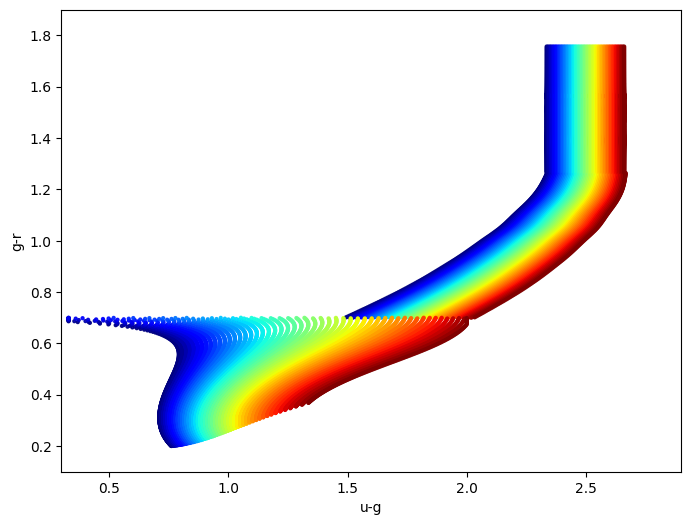

In [22]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(Lms['ug'], Lms['gr'], c=Lms['FeH'], cmap=plt.cm.jet, s=4.3, alpha=0.9)  
ax.set_xlim(0.3,2.9)
ax.set_ylim(0.1,1.9) 
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')


# Extract ug = f(FeH) at g-r = grBlue and ug = f(FeH)  g-r = grRed and

# linearly interpolate u-g=f(g-r | FeH) for intermediate g-r, at given FeH

In [24]:
# fix offsets in u-g
def adjustUGforSDSSlocus(locusSDSS, grBlue=0.5, grRed=1.0):
    # copy input locus
    locusSDSSaug = locusSDSS[(locusSDSS['Mr']>-100)&(locusSDSS['Mr']<100)]
    # colors
    colors = ['ug', 'gr', 'ri', 'iz', 'gi']
    # grid properties: 
    xLabel = 'FeH'
    yLabel = 'Mr'
    FeHGrid = locusSDSS[xLabel]
    MrGrid = locusSDSS[yLabel]
    FeH1d = np.sort(np.unique(FeHGrid))
    Mr1d = np.sort(np.unique(MrGrid))
    Mr1dStep = (Mr1d[1]-Mr1d[0])
    Mr1dMin = np.min(Mr1d)
    Mr1dMax = np.max(Mr1d)
    nStepMr = len(Mr1d) 
    nStepFeH = len(FeH1d) 
    ## loop over tables with FeH=const
    for i in range(0, nStepFeH):
        grBlueOK = False
        grRedOK = False
        # get interpolating parameters for the u-g color
        for j in range(int(i*nStepMr), int((i+1)*nStepMr)):
            if (~grBlueOK&(locusSDSSaug['gr'][j]>grBlue)):
                jBlue = j
                grBlueOK = True
            if (~grRedOK&(locusSDSSaug['gr'][j]>grRed)):
                jRed = j
                grRedOK = True
        LugBlue = locusSDSSaug['ug'][jBlue] 
        LugRed = locusSDSSaug['ug'][jRed] 
        LgrBlue = locusSDSSaug['gr'][jBlue] 
        LgrRed = locusSDSSaug['gr'][jRed] 
        # now overwrite u-g color
        for j in range(int(i*nStepMr), int((i+1)*nStepMr)):  
            if ((j>=jBlue)&(j<jRed)):               
                dgr = (locusSDSSaug['gr'][j]-LgrBlue)/(LgrRed-LgrBlue)
                dug = LugRed - LugBlue
                locusSDSSaug['ug'][j] = locusSDSSaug['ug'][jBlue] + dug*dgr 
    return locusSDSSaug

In [25]:
Ladj = adjustUGforSDSSlocus(Lms, grBlue=0.5, grRed=1.0)

Text(0, 0.5, 'g-r')

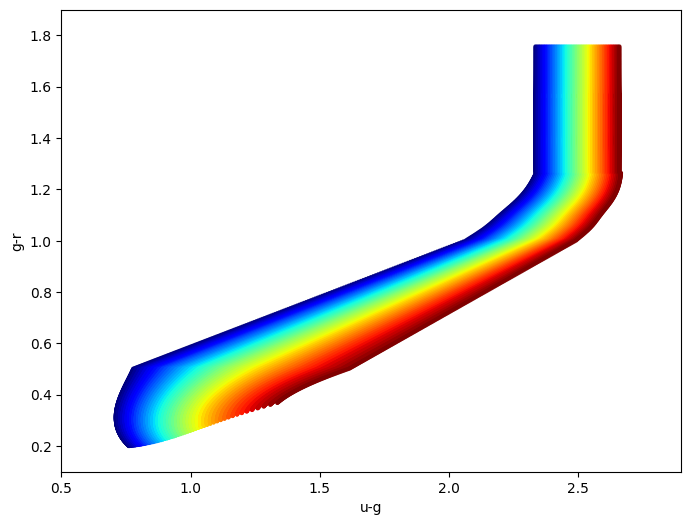

In [26]:
# plot new locus
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(Ladj['ug'], Ladj['gr'], c=Ladj['FeH'], cmap=plt.cm.jet, s=4.3, alpha=0.9)  
ax.set_xlim(0.5,2.9)
ax.set_ylim(0.1,1.9) 
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')

Text(0, 0.5, 'g-r')

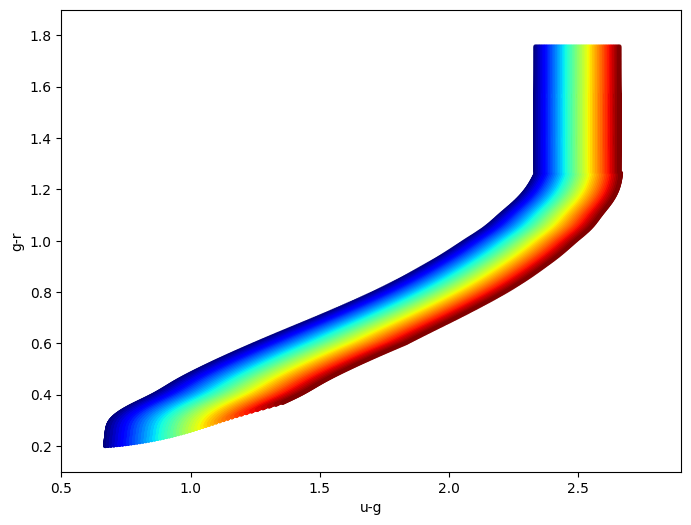

In [27]:
Lms2 = Lok[(Lok['Mr']>4)&(Lok['Mr']<16)]
# plot old locus
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(Lms2['ug'], Lms2['gr'], c=Lms2['FeH'], cmap=plt.cm.jet, s=4.3, alpha=0.9)  
ax.set_xlim(0.5,2.9)
ax.set_ylim(0.1,1.9) 
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')

old SDSS, FeH range: -2.5 0.0
new FeH range: -2.5 0.0
made plot: compare2isochrones_adjustUGvsFeH.png


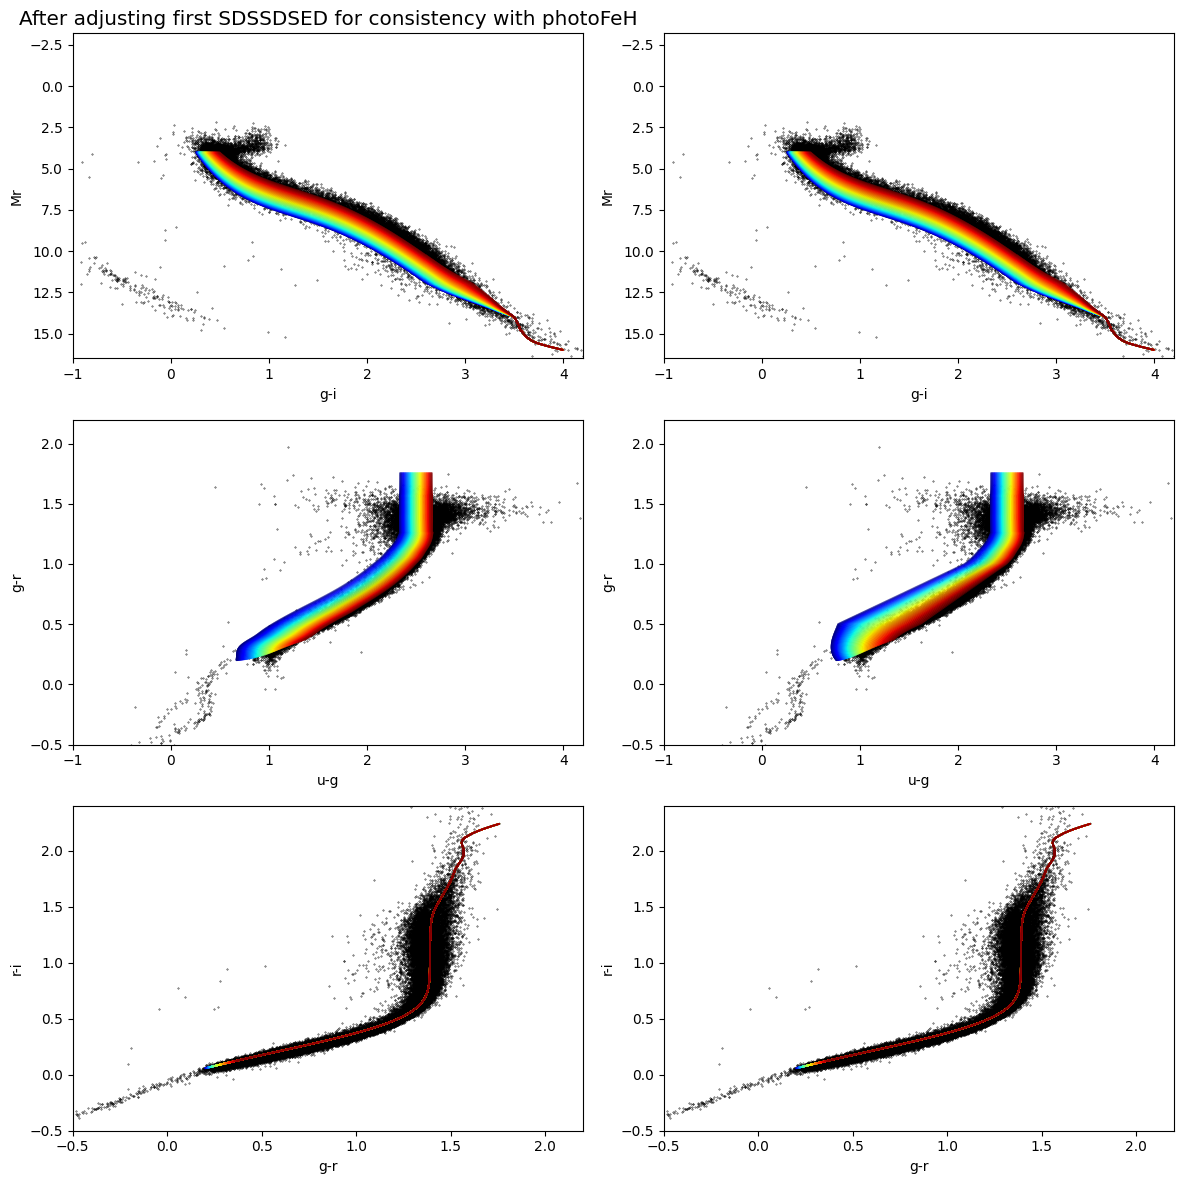

In [28]:
Pdf1 = Lms2
Pdf2 = Ladj
print('old SDSS, FeH range:', np.min(Pdf1['FeH']), np.max(Pdf1['FeH']))
print('new FeH range:', np.min(Pdf2['FeH']), np.max(Pdf2['FeH']))
pname = 'compare2isochrones_adjustUGvsFeH.png'
title = 'After adjusting first SDSSDSED for consistency with photoFeH'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.4, alpha2=0.4, title=title, plotname=pname)

## 1) extend SDSS locus to 0 < FeH < 0.5 range

In [29]:
locusExtendedHighFeH = lt.extendLocusHighFeH(Ladj)
len(locusExtendedHighFeH)

73139

In [30]:
locusSDSS = locusExtendedHighFeH[locusExtendedHighFeH['Mr']<16.001]
len(locusSDSS)

73139

SDSS, FeH range: -2.5 0.0
Extended FeH range: -2.5 0.5
made plot: compare2isochrones_SDSSorigSDSSextendedFeH.png


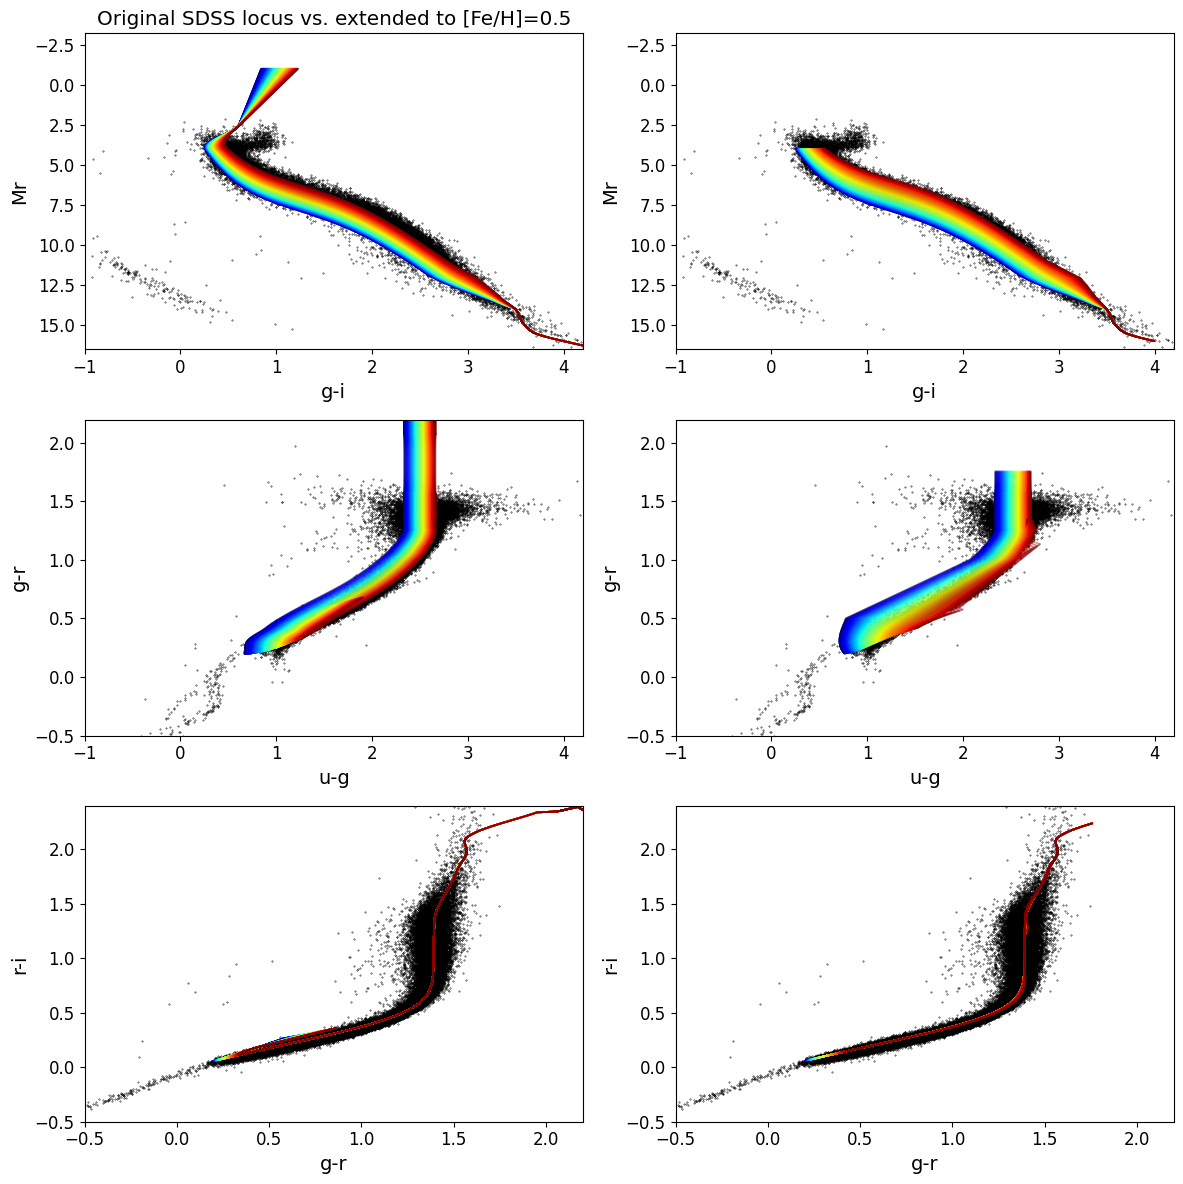

In [31]:
Pdf1 = Lok
Pdf2 = locusSDSS
print('SDSS, FeH range:', np.min(Pdf1['FeH']), np.max(Pdf1['FeH']))
print('Extended FeH range:', np.min(Pdf2['FeH']), np.max(Pdf2['FeH']))
pname = 'compare2isochrones_SDSSorigSDSSextendedFeH.png'
title = 'Original SDSS locus vs. extended to [Fe/H]=0.5'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.4, alpha2=0.4, title=title, plotname=pname)

(-0.2, 1.85)

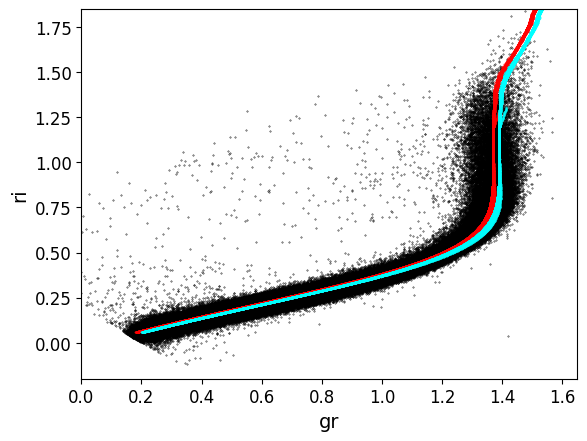

In [84]:
# perhaps up to 0.02 mag shift in g-r, but (see below)...
df = s82gaiaPhD
plt.scatter(df['gr'], df['ri'], c='black', s=0.1)  
df = Pdf2 
plt.scatter(df['gr']-0.02, df['ri'], c='red', s=0.1)  
plt.scatter(df['gr'], df['ri'], c='cyan', s=0.1)  
plt.xlabel('gr')
plt.ylabel('ri') 
plt.xlim(0.0, 1.65)
plt.ylim(-0.2, 1.85)

In [85]:
# ...w color agrees for s82gaiaB and Pdf2 
flag = (s82gaiaB['gr']>0.4)&(s82gaiaB['gr']<1.0)
p1p2 = s82gaiaB[flag]
p1p2L = Pdf2[(Pdf2['gr']>0.4)&(Pdf2['gr']<1.0)]
w = -0.227*(p1p2['g_mMed']-p1p2['Ag']) + 0.792*(p1p2['r_mMed']-p1p2['Ar'])
w += -0.567*(p1p2['i_mMed']-p1p2['Ai']) + 0.05
w2 = -0.227*(p1p2['gr']-0.0000) + 0.567*(p1p2['ri']-0.0000) + 0.017
w2L = -0.227*(p1p2L['gr']-0.0002) + 0.567*(p1p2L['ri']-0.0000) + 0.017
print(np.median(w), bt.sigGzi(w))
print(np.median(w2), bt.sigGzi(w2))
print(np.median(w2L), bt.sigGzi(w2L))

-0.0014076594999989922 0.011408725545751225
0.00020888700000040727 0.012109931622750805
0.0011804399999999354 0.0024614148975000204


## new Dartmouth locus: Dartmouth Stellar Evolution Database (DSED)

### for more plots, see augmentLocusTable.ipynb

In [86]:
DSEDdatadir = '../data/DSED/'
ages, FeHlist, DSEDiso, DSEDlocii = lt.readAllDSED(DSEDdatadir) 

made plot: compare2isochronesColorMr_SDSS_vs_DSED_10Gyr.png


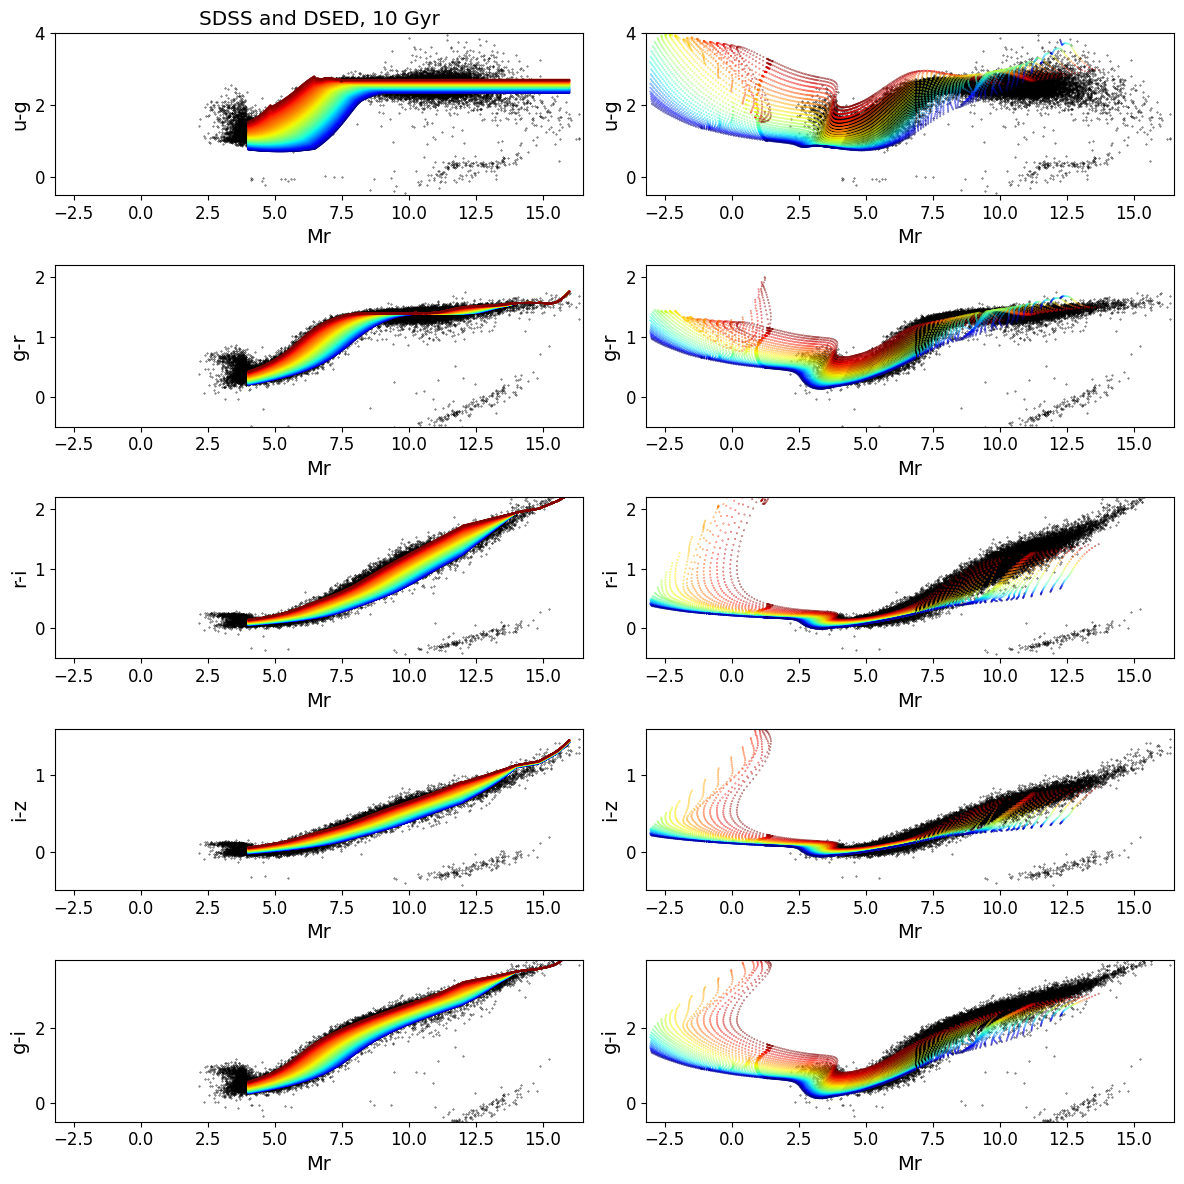

In [87]:
Pdf1 = locusSDSS
Pdf2 = DSEDlocii[ages.index(10)] 
pname = 'compare2isochronesColorMr_SDSS_vs_DSED_10Gyr.png'
title = 'SDSS and DSED, 10 Gyr'
pp.compare2isochronesColorMr(s82gaiaPi, Pdf1, Pdf2, alpha1=0.8, alpha2=0.8, title=title, plotname=pname)

made plot: compare2isochrones_SDSS_vs_DSED_10Gyr.png


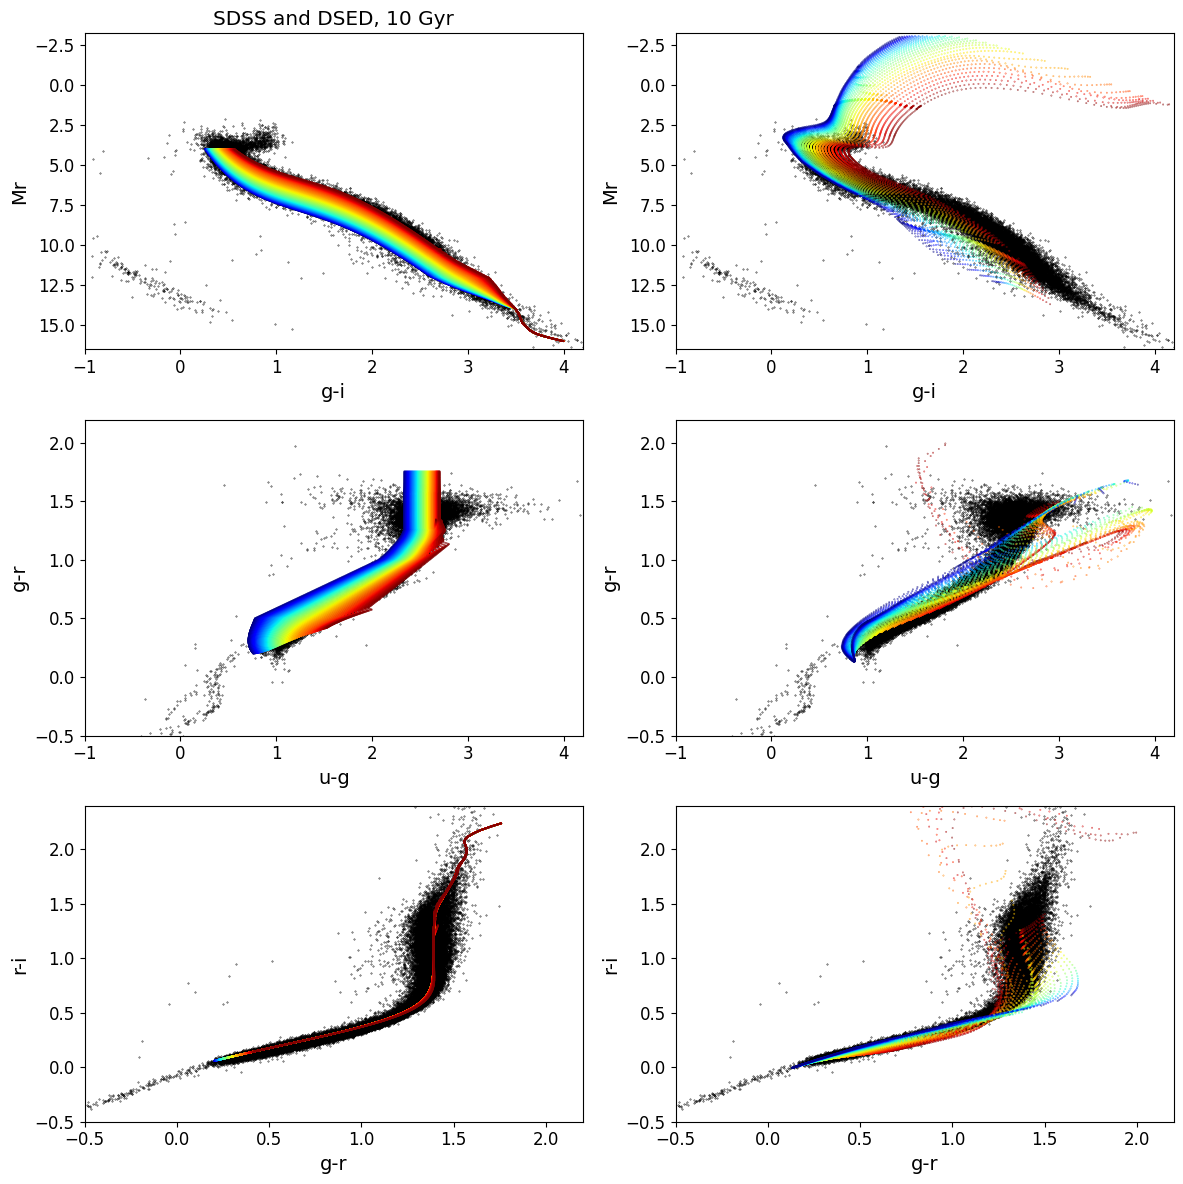

In [88]:
Pdf1 = locusSDSS
Pdf2 = DSEDlocii[ages.index(10)] 
pname = 'compare2isochrones_SDSS_vs_DSED_10Gyr.png'
title = 'SDSS and DSED, 10 Gyr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.8, alpha2=0.8, title=title, plotname=pname)

made plot: compare2isochrones_DSED_1Gyr_vs_DSED_10Gyr_byMr.png


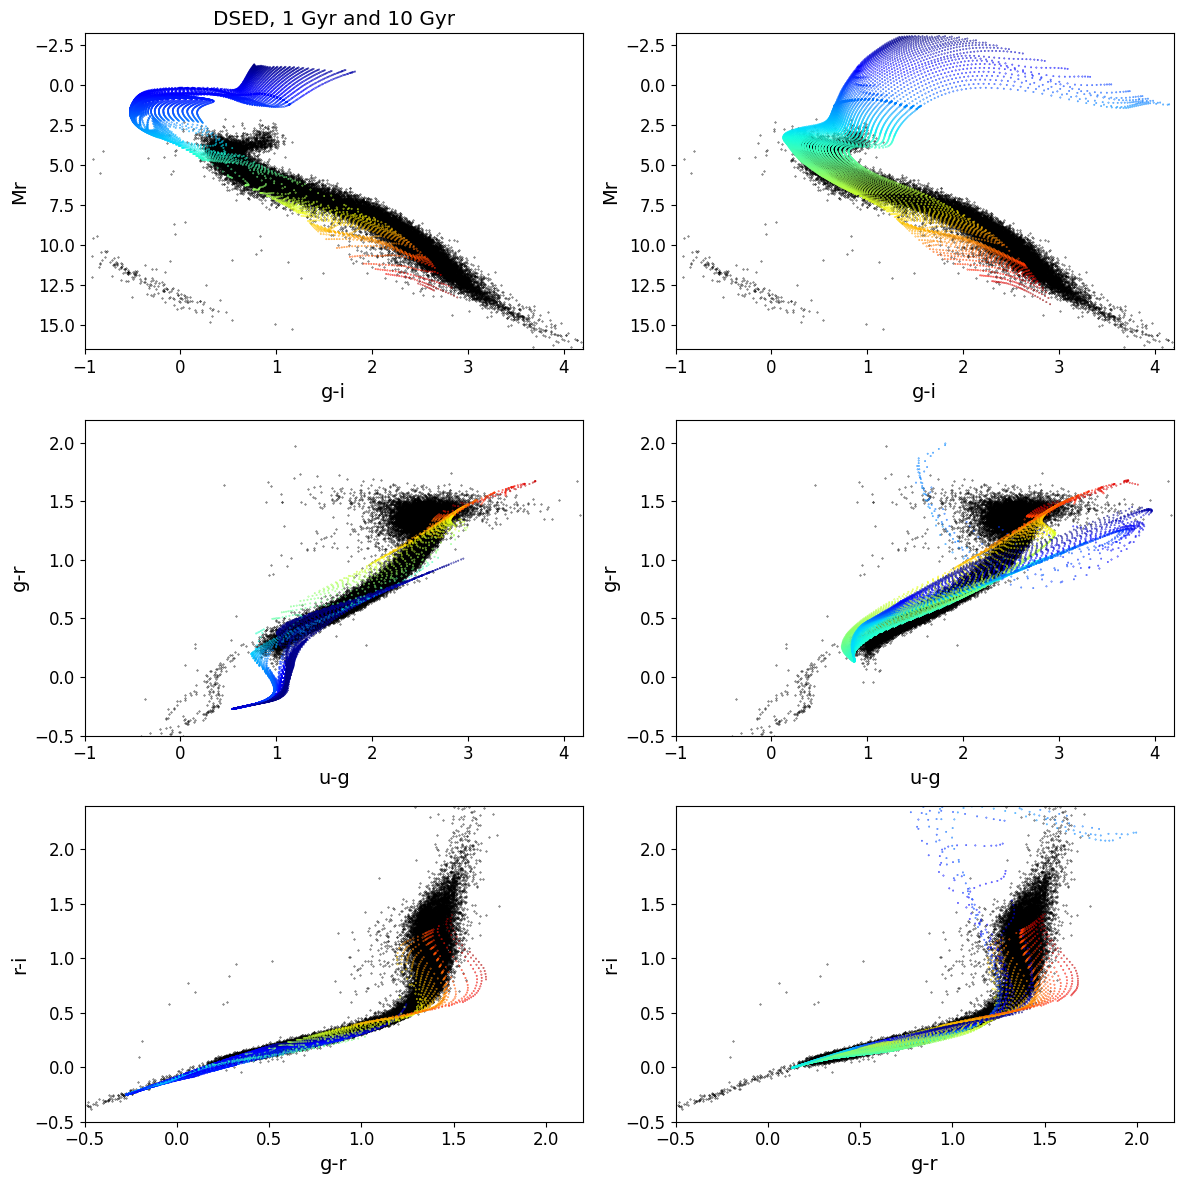

In [89]:
Pdf1 = DSEDlocii[ages.index(1)] 
Pdf2 = DSEDlocii[ages.index(10)] 
pname = 'compare2isochrones_DSED_1Gyr_vs_DSED_10Gyr_byMr.png'
title = 'DSED, 1 Gyr and 10 Gyr'
pp.compare2isochrones2(s82gaiaPi, Pdf1, Pdf2, alpha1=1.0, alpha2=1.0, title=title, plotname=pname)

made plot: compare2isochrones_DSED_2Gyr_vs_DSED_5Gyr.png


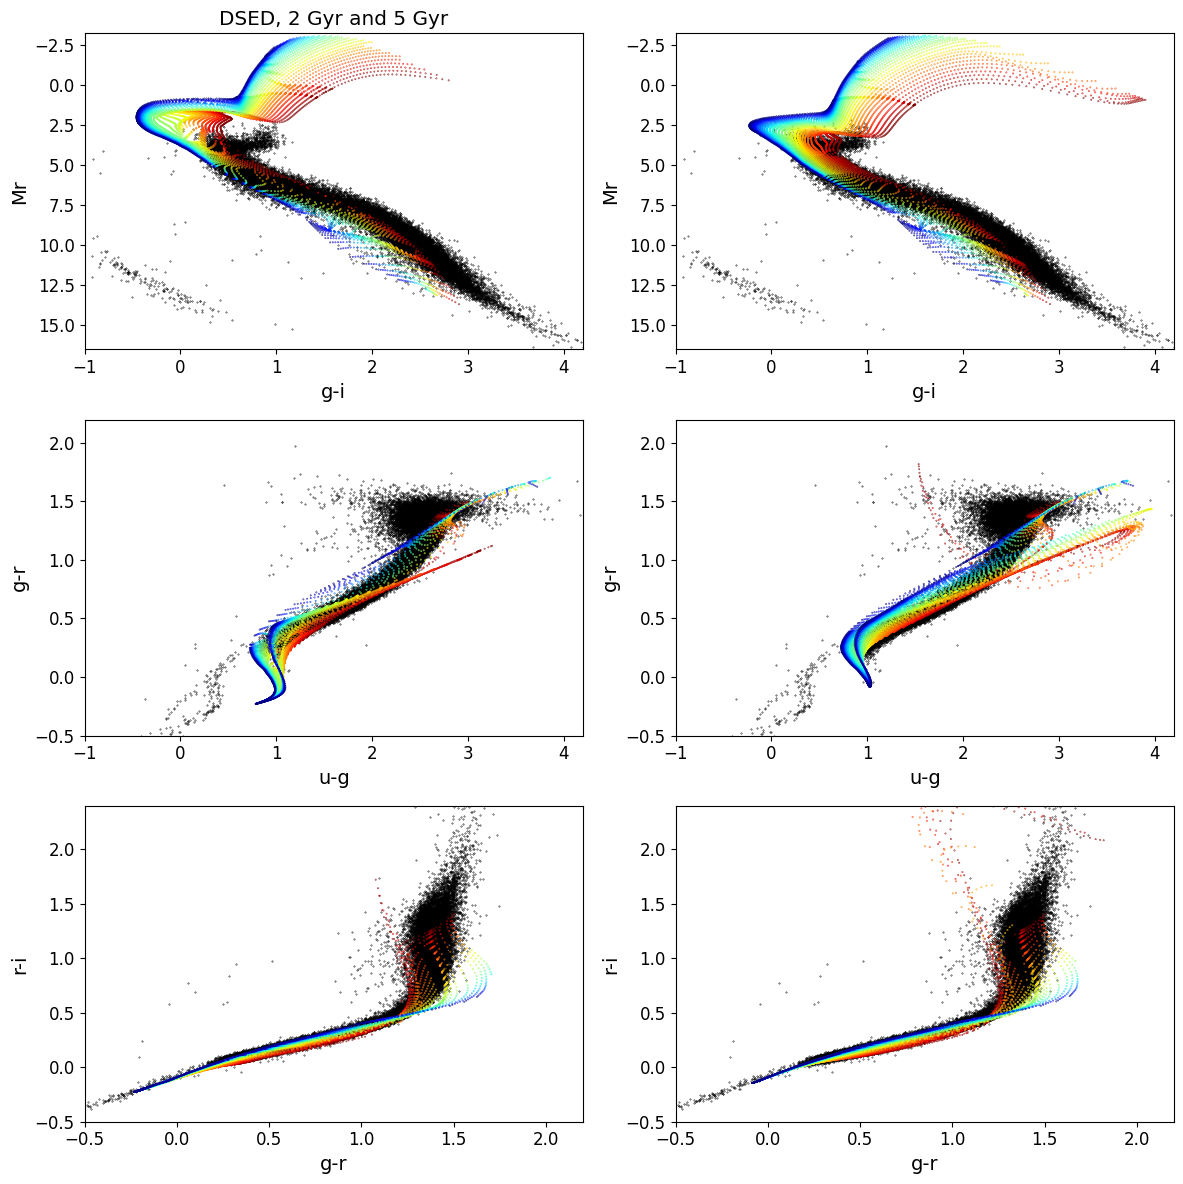

In [90]:
Pdf1 = DSEDlocii[ages.index(2)] 
Pdf2 = DSEDlocii[ages.index(5)] 
pname = 'compare2isochrones_DSED_2Gyr_vs_DSED_5Gyr.png'
title = 'DSED, 2 Gyr and 5 Gyr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=1.0, alpha2=1.0, title=title, plotname=pname)

made plot: compare2isochrones_DSED_10Myr_vs_DSED_100Myr.png


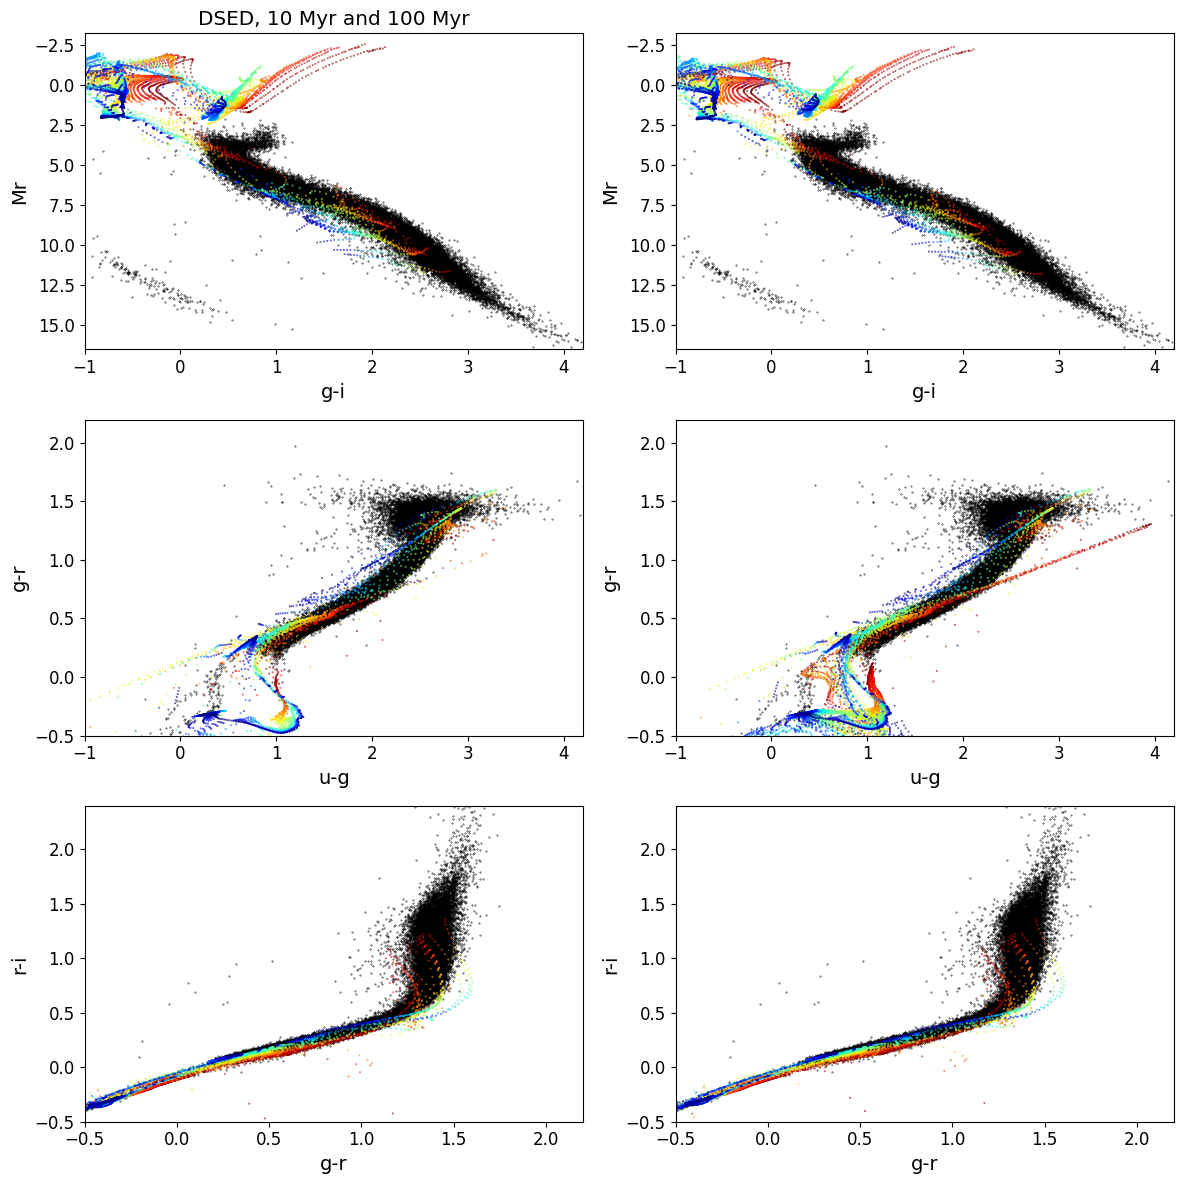

In [91]:
Pdf1 = DSEDlocii[ages.index(0.01)] 
Pdf2 = DSEDlocii[ages.index(0.1)] 
pname = 'compare2isochrones_DSED_10Myr_vs_DSED_100Myr.png'
title = 'DSED, 10 Myr and 100 Myr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=1.0, alpha2=1.0, title=title, plotname=pname)

made plot: compare2isochronesColorMrAlongLocus_DSED_1Gyr_vs_DSED_10Gyr_byMr.png


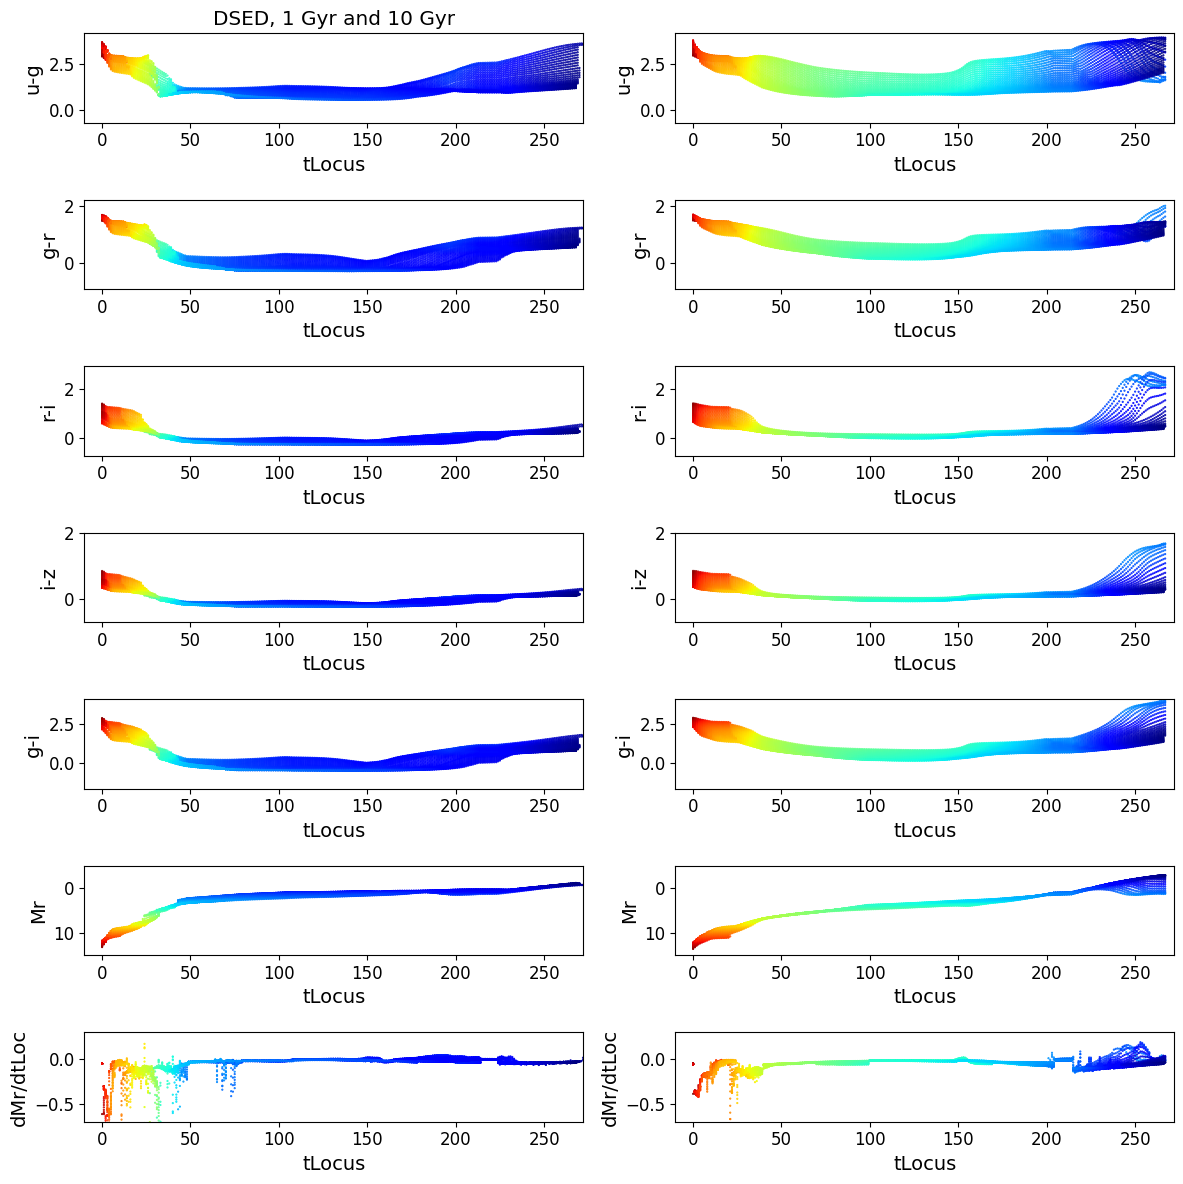

In [92]:
import paperPlots as pp
Pdf1 = DSEDlocii[ages.index(1)] 
Pdf2 = DSEDlocii[ages.index(10)] 
pname = 'compare2isochronesColorMrAlongLocus_DSED_1Gyr_vs_DSED_10Gyr_byMr.png'
title = 'DSED, 1 Gyr and 10 Gyr'
pp.compare2isochronesColorMrAlongLocus2(Pdf1, Pdf2, alpha=1.0, title=title, plotname=pname)

made plot: compare2isochronesColorMrAlongLocus_DSED_1Gyr_vs_DSED_10Gyr.png


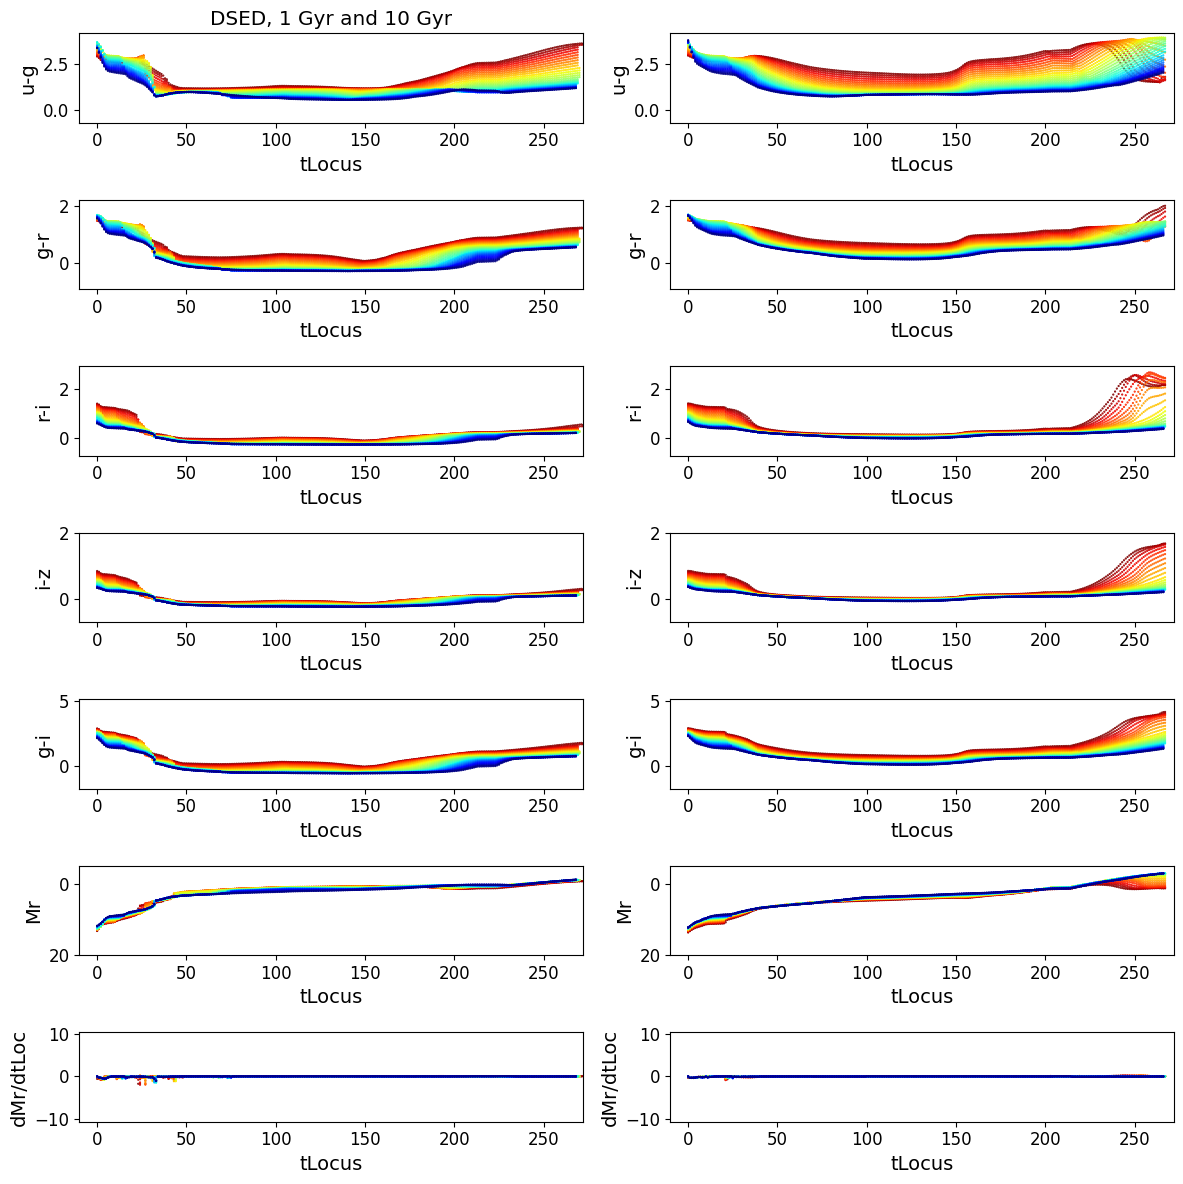

In [93]:
import paperPlots as pp
Pdf1 = DSEDlocii[ages.index(1)] 
Pdf2 = DSEDlocii[ages.index(10)] 
pname = 'compare2isochronesColorMrAlongLocus_DSED_1Gyr_vs_DSED_10Gyr.png'
title = 'DSED, 1 Gyr and 10 Gyr'
pp.compare2isochronesColorMrAlongLocus(Pdf1, Pdf2, alpha=1.0, title=title, plotname=pname)

made plot: compare2isochronesColorMrAlongLocus_DSED_10Myr_vs_DSED_100Myr.png


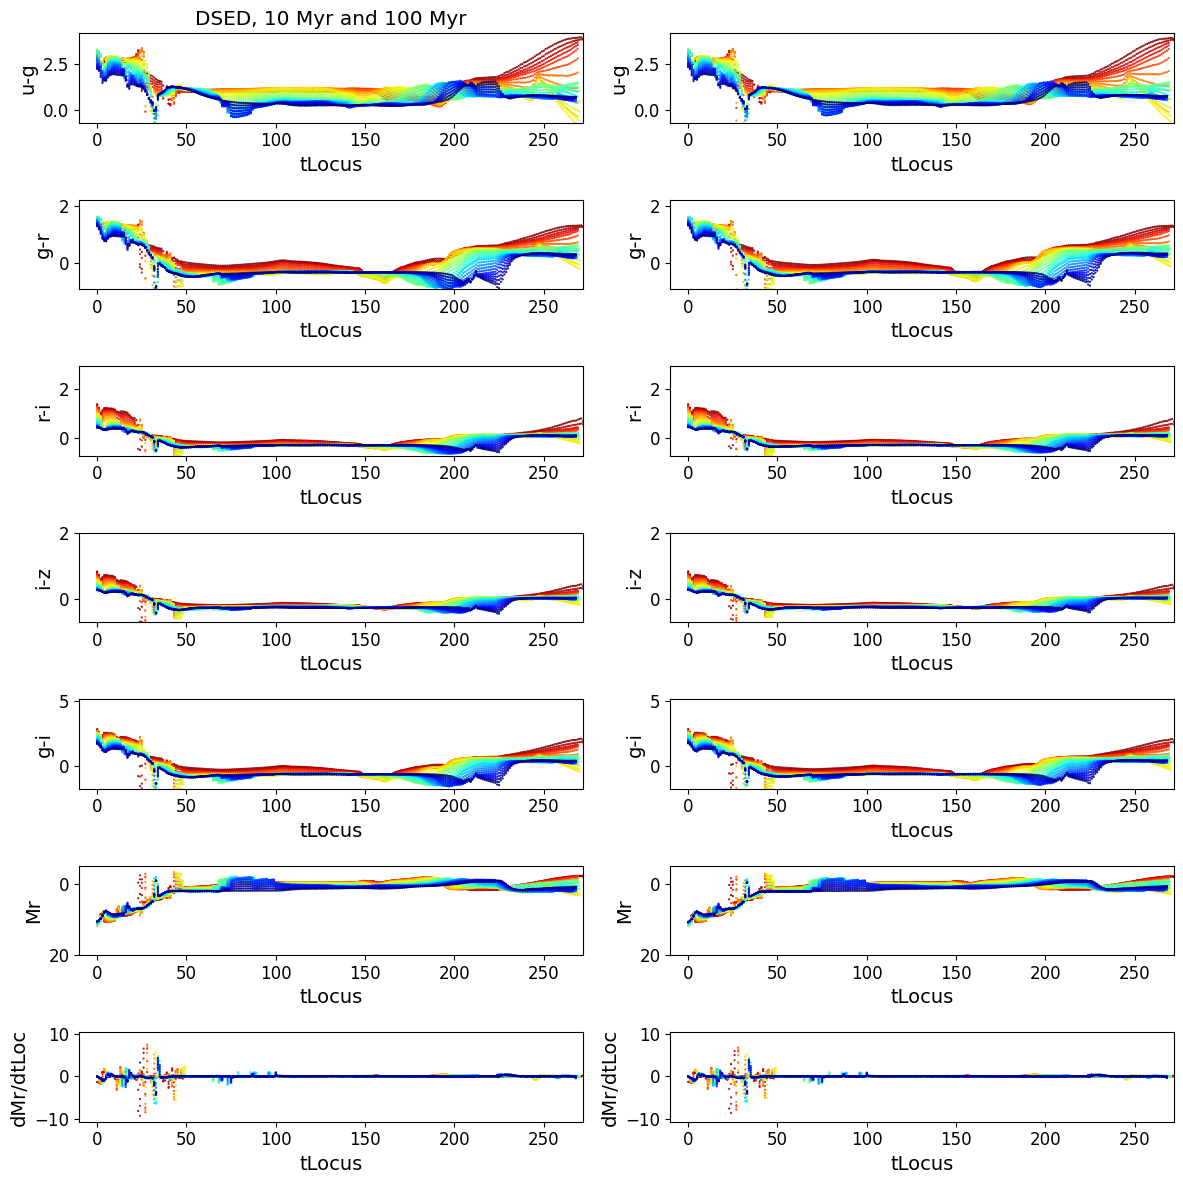

In [94]:
import paperPlots as pp
Pdf3 = DSEDlocii[ages.index(0.01)] 
Pdf4 = DSEDlocii[ages.index(0.1)] 
pname = 'compare2isochronesColorMrAlongLocus_DSED_10Myr_vs_DSED_100Myr.png'
title = 'DSED, 10 Myr and 100 Myr'
pp.compare2isochronesColorMrAlongLocus(Pdf3, Pdf4, alpha=1.0, title=title, plotname=pname)

## 2) replace Mr < 4 part with DSED isocrones

In [95]:
locusDSED1 = DSEDlocii[ages.index(1)]
locusDSED2 = DSEDlocii[ages.index(2)]
locusDSED5 = DSEDlocii[ages.index(5)]
locusDSED10 = DSEDlocii[ages.index(10)]

In [96]:
StitchedLocus1 = lt.augmentSDSSlocusWithIsochrone(locusSDSS, locusDSED1, MrStitch=4.0)
StitchedLocus2 = lt.augmentSDSSlocusWithIsochrone(locusSDSS, locusDSED2, MrStitch=4.0)
StitchedLocus5 = lt.augmentSDSSlocusWithIsochrone(locusSDSS, locusDSED5, MrStitch=4.0)
StitchedLocus10 = lt.augmentSDSSlocusWithIsochrone(locusSDSS, locusDSED10, MrStitch=4.0)

made plot: compare2isochrones_SDSS-DSED_1Gyr_vs_10Gyr.png


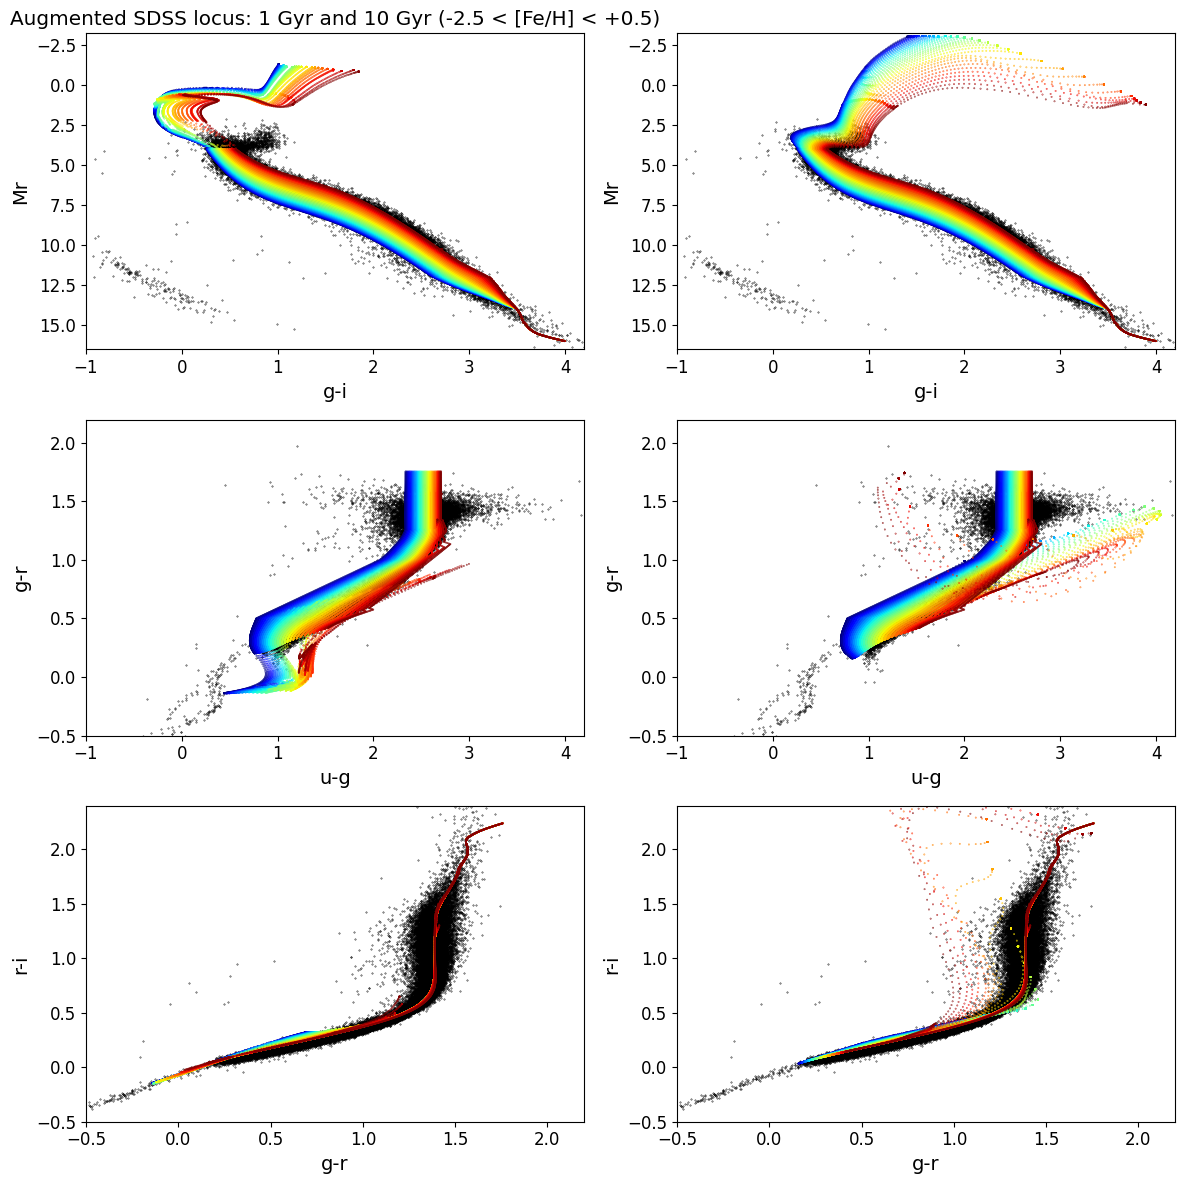

In [100]:
import paperPlots as pp
Pdf1 = StitchedLocus1
Pdf2 = StitchedLocus10 
pname = 'compare2isochrones_SDSS-DSED_1Gyr_vs_10Gyr.png'
title = 'Augmented SDSS locus: 1 Gyr and 10 Gyr (-2.5 < [Fe/H] < +0.5)'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.95, alpha2=0.95, title=title, plotname=pname) 
!cp compare2isochrones_SDSS-DSED_1Gyr_vs_10Gyr.png compare2isochrones_augmentedSDSS_1Gyr_10Gyr.png

made plot: compare2isochrones_SDSS-DSED_2Gyr_vs_5Gyr.png


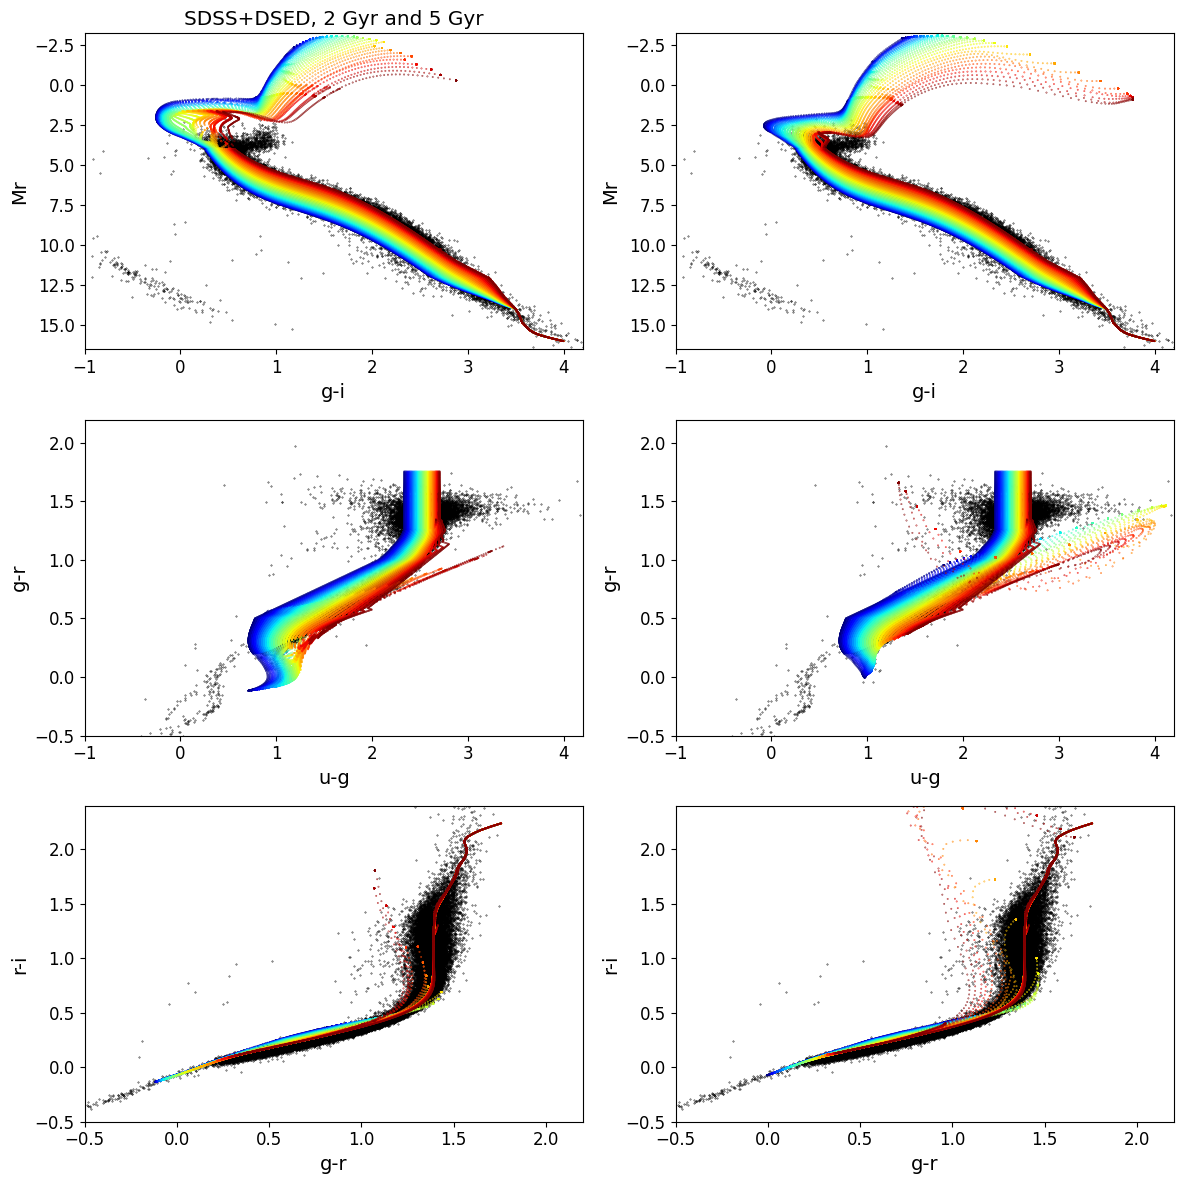

In [101]:
import paperPlots as pp
Pdf1 = StitchedLocus2
Pdf2 = StitchedLocus5 
pname = 'compare2isochrones_SDSS-DSED_2Gyr_vs_5Gyr.png'
title = 'SDSS+DSED, 2 Gyr and 5 Gyr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.95, alpha2=0.95, title=title, plotname=pname) 

made plot: compare2isochronesColorMrAlongLocus_TEST.png


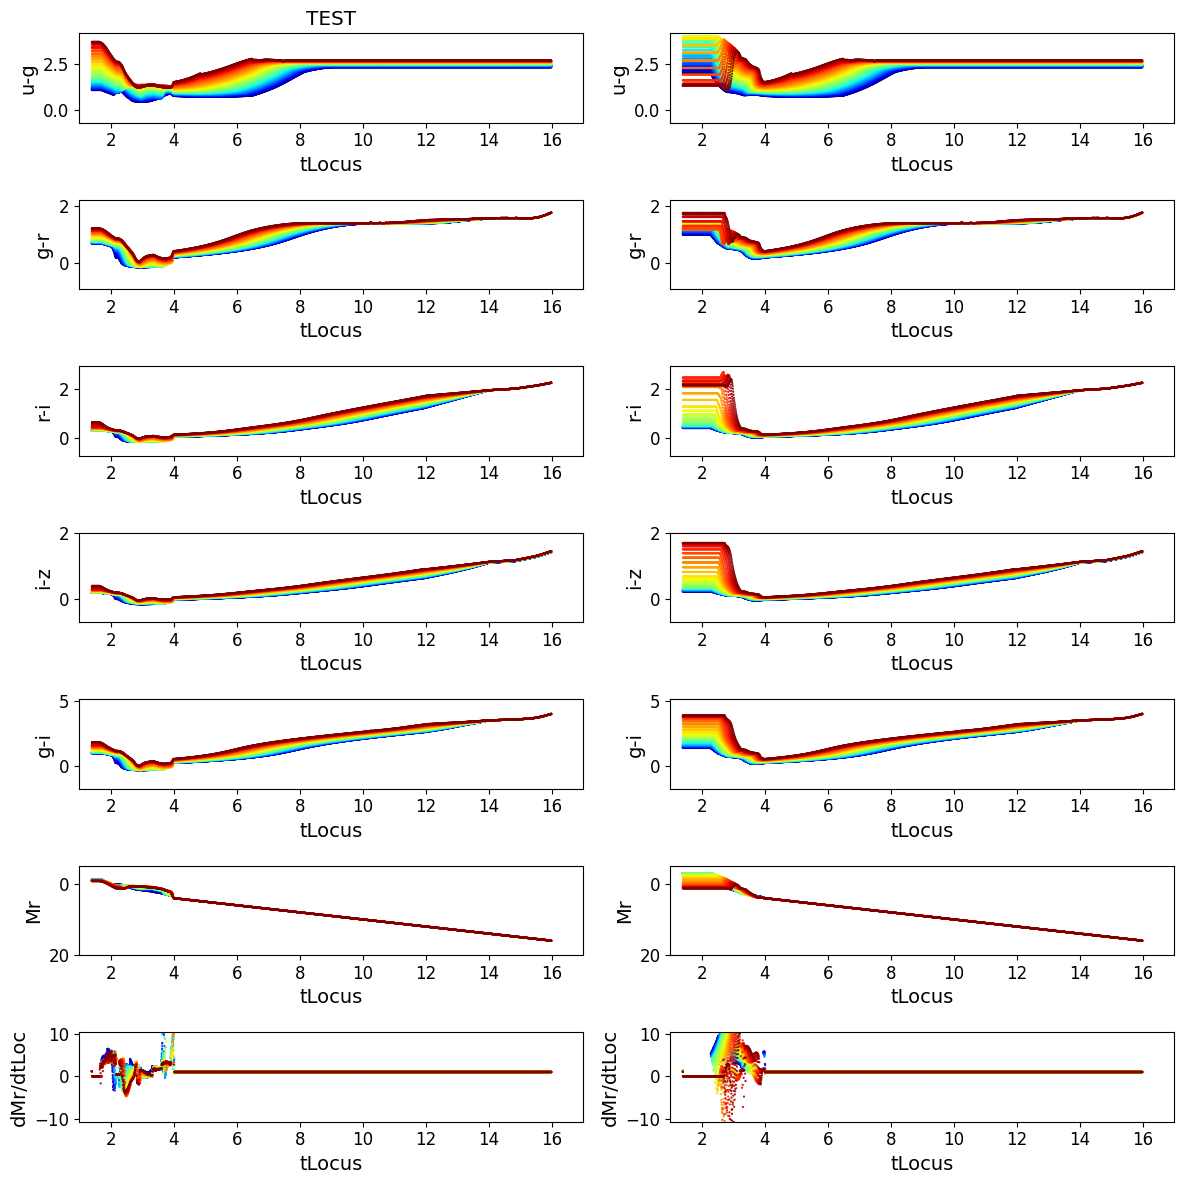

In [102]:
import paperPlots as pp
Pdf3 = StitchedLocus1
Pdf4 = StitchedLocus10  
pname = 'compare2isochronesColorMrAlongLocus_TEST.png'
title = 'TEST'
pp.compare2isochronesColorMrAlongLocus(Pdf3, Pdf4, alpha=1.0, title=title, plotname=pname, tMin=1, tMax=17)

In [103]:
len(StitchedLocus1), len(StitchedLocus10)

(45229, 45229)

In [104]:
# assumes this notebook is called from directory ./PhotoD/notebooks/ 
datafile = '../data/PARSEC/PARSEC_logAge7.0_FeHgrid.txt'
P10m = lt.PARSEClocus(datafile)
datafile = '../data/PARSEC/PARSEC_logAge8.0_FeHgrid.txt'
P100m = lt.PARSEClocus(datafile)
datafile = '../data/PARSEC/PARSEC_logAge9.0_FeHgrid.txt'
P1 = lt.PARSEClocus(datafile)
datafile = '../data/PARSEC/PARSEC_logAge10.0_FeHgrid.txt'
P10 = lt.PARSEClocus(datafile)

PARSEC, FeH range: -2.19174 0.5
DSED, FeH range: -2.5 0.5
made plot: compare2isocrones_PARSECvsDSED10Gyr.png


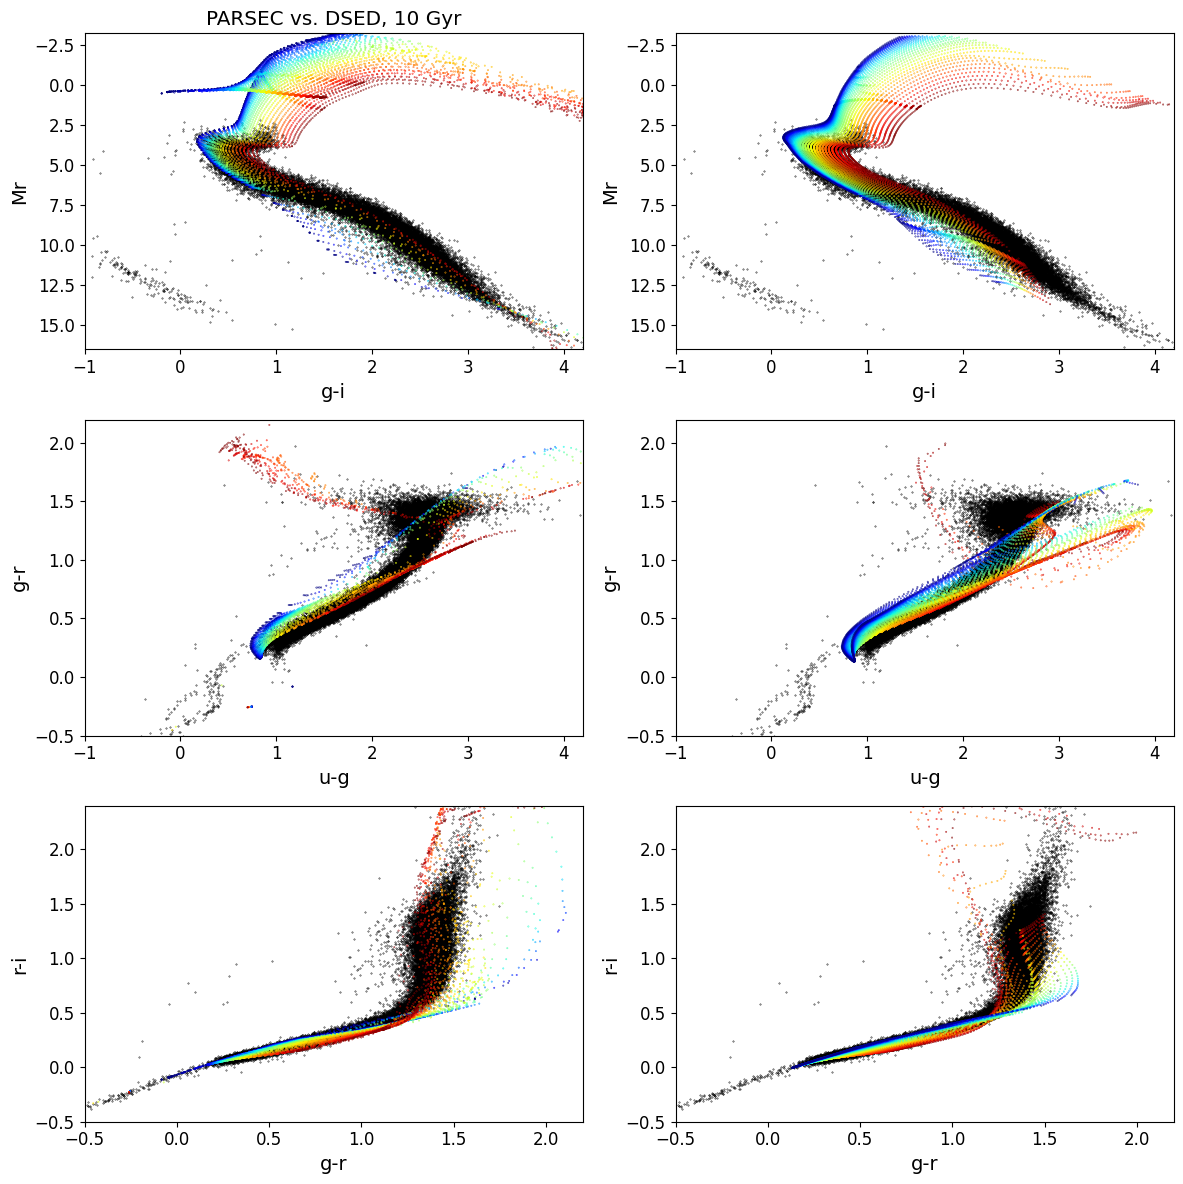

In [105]:
Pdf1 = P10
Pdf2 = DSEDlocii[ages.index(10)] 
print('PARSEC, FeH range:', np.min(Pdf1['FeH']), np.max(Pdf1['FeH']))
print('DSED, FeH range:', np.min(Pdf2['FeH']), np.max(Pdf2['FeH']))
pname = 'compare2isocrones_PARSECvsDSED10Gyr.png'
title = 'PARSEC vs. DSED, 10 Gyr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.98, alpha2=0.98, title=title, plotname=pname)

PARSEC, FeH range: -2.19174 0.5
DSED, FeH range: -2.5 0.5
made plot: compare2isocrones_PARSECvsDSED1Gyr.png


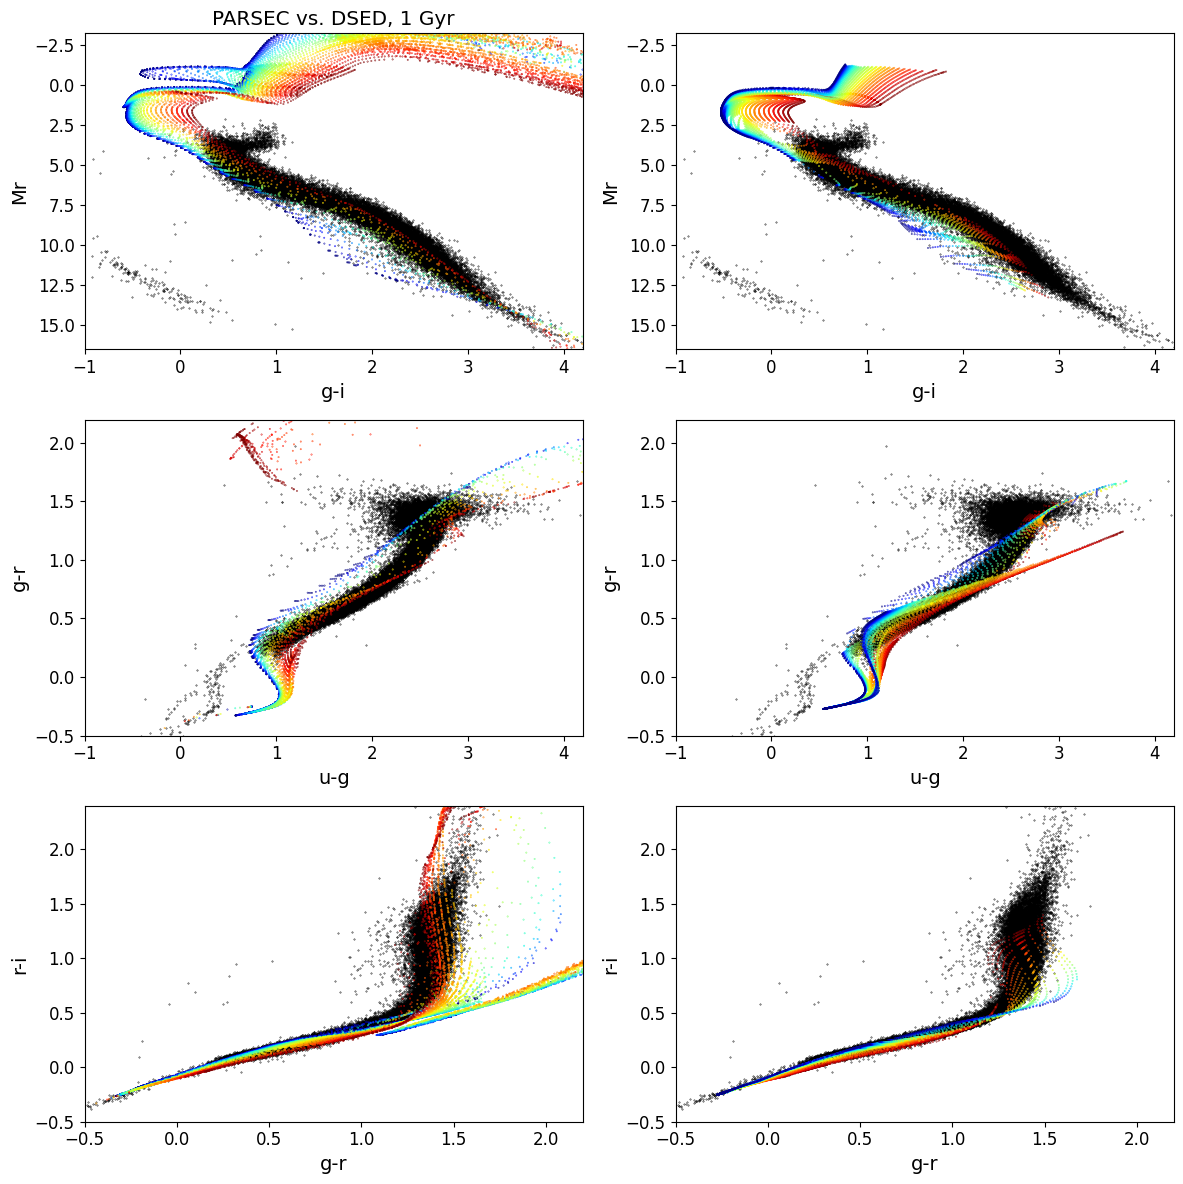

In [106]:
Pdf1 = P1
Pdf2 = DSEDlocii[ages.index(1)] 
print('PARSEC, FeH range:', np.min(Pdf1['FeH']), np.max(Pdf1['FeH']))
print('DSED, FeH range:', np.min(Pdf2['FeH']), np.max(Pdf2['FeH']))
pname = 'compare2isocrones_PARSECvsDSED1Gyr.png'
title = 'PARSEC vs. DSED, 1 Gyr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.98, alpha2=0.98, title=title, plotname=pname)

PARSEC, FeH range: -2.19174 0.5
DSED, FeH range: -2.19174 0.5
made plot: compare2isocrones_PARSEC_10M_100M.png


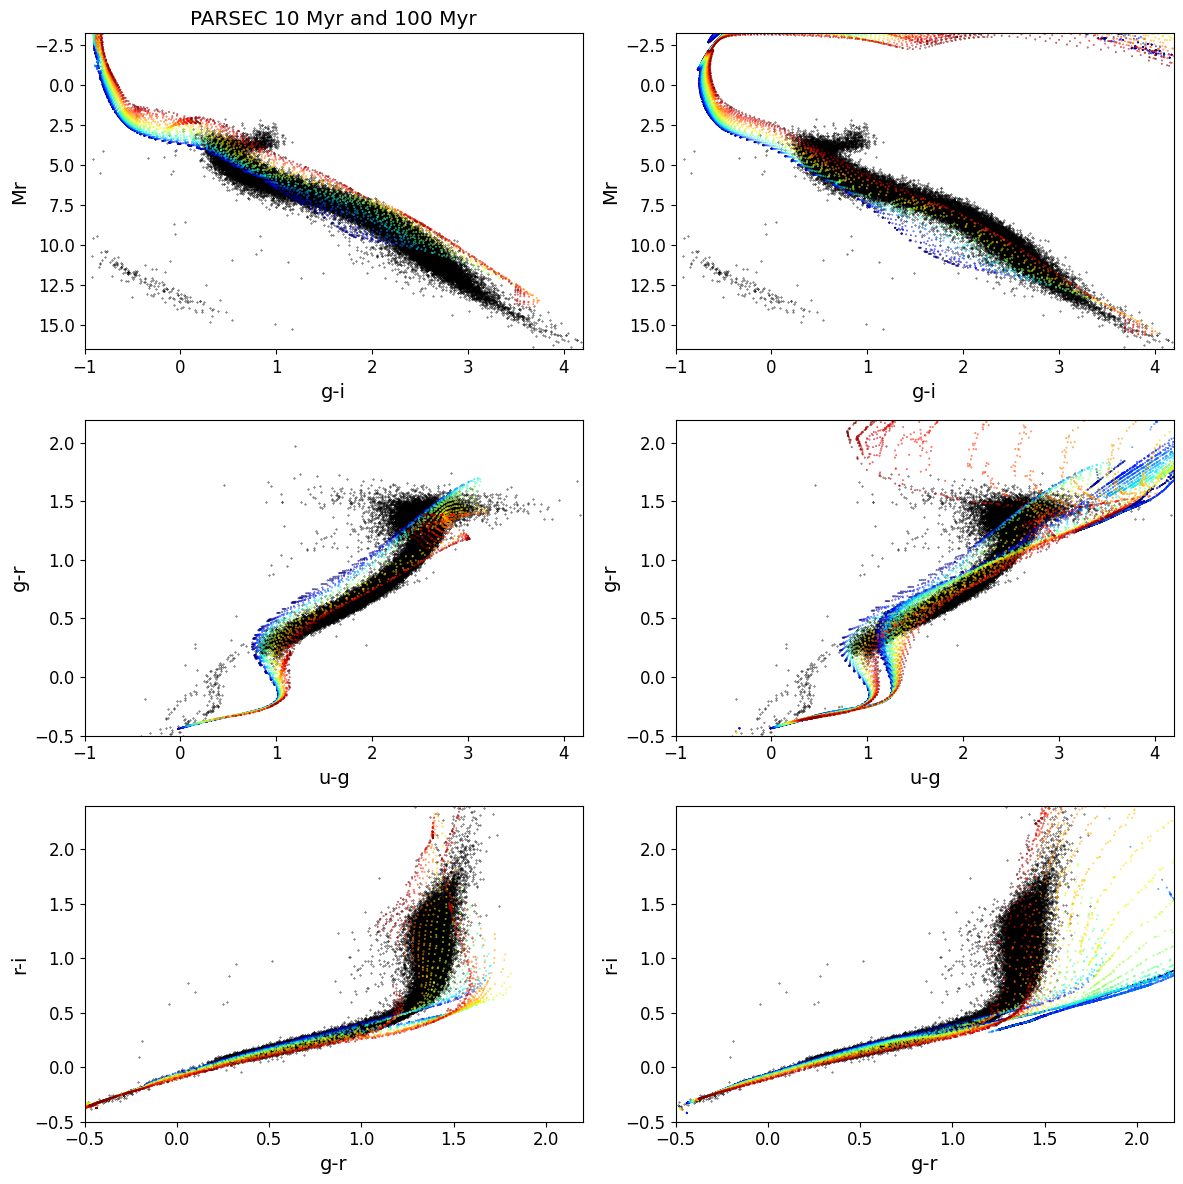

In [107]:
Pdf1 = P10m
Pdf2 = P100m
print('PARSEC, FeH range:', np.min(Pdf1['FeH']), np.max(Pdf1['FeH']))
print('DSED, FeH range:', np.min(Pdf2['FeH']), np.max(Pdf2['FeH']))
pname = 'compare2isocrones_PARSEC_10M_100M.png'
title = 'PARSEC 10 Myr and 100 Myr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.98, alpha2=0.98, title=title, plotname=pname)

## store new stiched SDSS+DSED tables

In [112]:
header = '# SDSS locus augmented with DSED isochrones for 1 Gyr'
lt.dumpSDSSDSEDlocus(StitchedLocus1, header, '../data/LocusData/SDSSDSEDlocus_1Gyr.txt')

made catalog: ../data/LocusData/SDSSDSEDlocus_1Gyr.txt


In [113]:
header = '# SDSS locus augmented with DSED isochrones for 2 Gyr'
lt.dumpSDSSDSEDlocus(StitchedLocus2, header, '../data/LocusData/SDSSDSEDlocus_2Gyr.txt')

made catalog: ../data/LocusData/SDSSDSEDlocus_2Gyr.txt


In [114]:
header = '# SDSS locus augmented with DSED isochrones for 5 Gyr'
lt.dumpSDSSDSEDlocus(StitchedLocus5, header, '../data/LocusData/SDSSDSEDlocus_5Gyr.txt') 

made catalog: ../data/LocusData/SDSSDSEDlocus_5Gyr.txt


In [115]:
header = '# SDSS locus augmented with DSED isochrones for 10 Gyr'
lt.dumpSDSSDSEDlocus(StitchedLocus10, header, '../data/LocusData/SDSSDSEDlocus_10Gyr.txt')

made catalog: ../data/LocusData/SDSSDSEDlocus_10Gyr.txt


In [116]:
## test
datafile = '../data/LocusData/SDSSDSEDlocus_1Gyr.txt'
Locus1 = lt.readSDSSDSEDlocus(datafile, fixForStripe82=False)
datafile = '../data/LocusData/SDSSDSEDlocus_10Gyr.txt'
Locus10 = lt.readSDSSDSEDlocus(datafile, fixForStripe82=False)

made plot: compare2isochrones_SDSS-DSED_1Gyr_vs_10Gyr.png


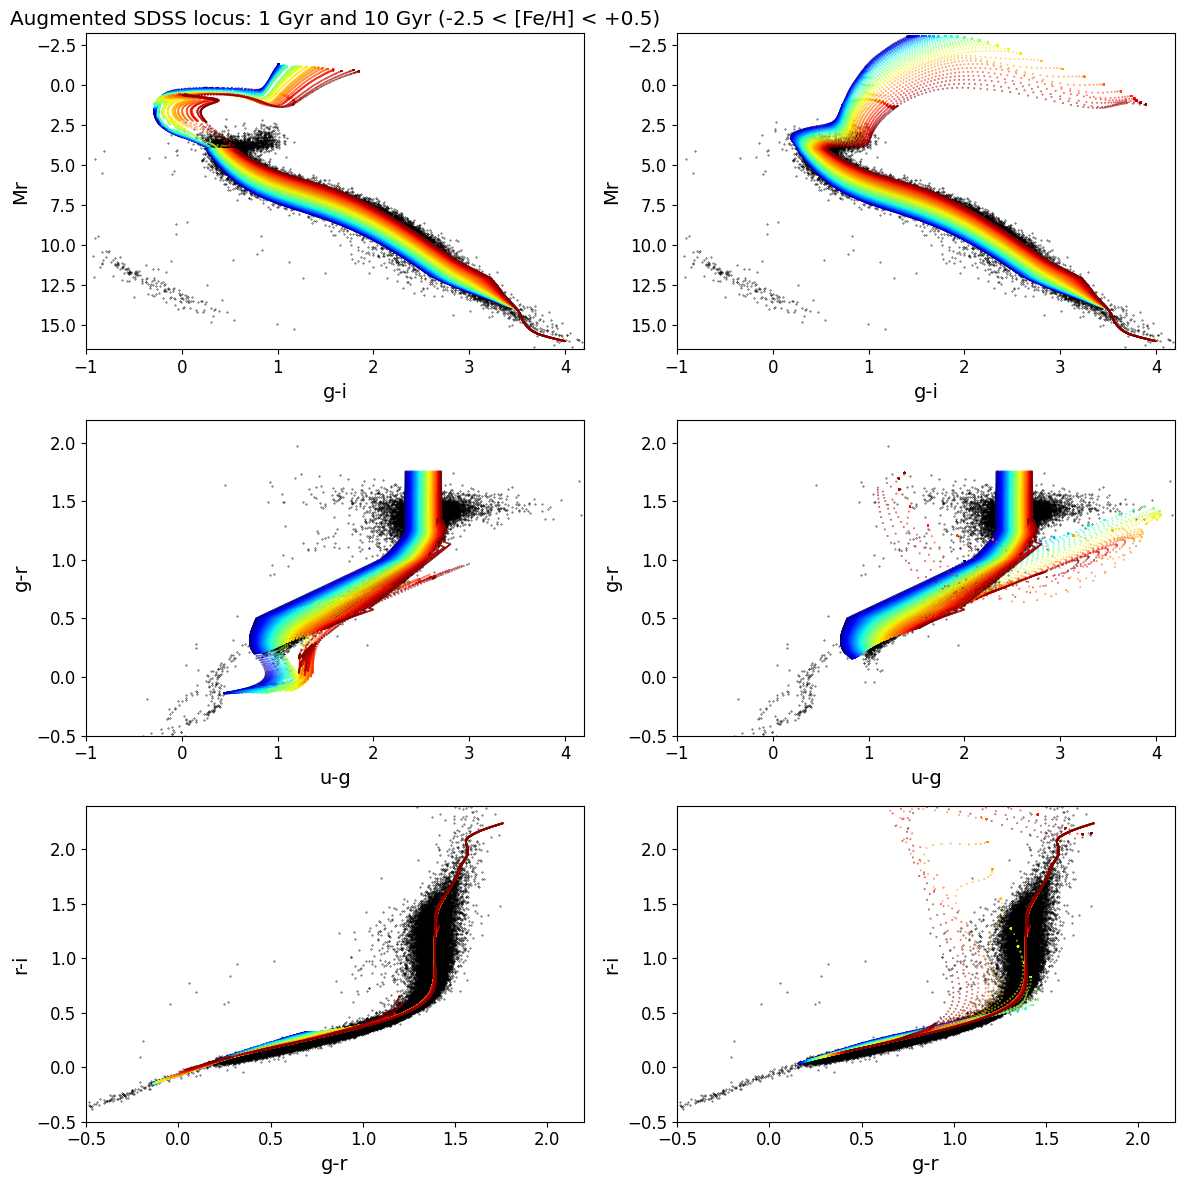

In [117]:
Pdf1 = Locus1
Pdf2 = Locus10 
pname = 'compare2isochrones_SDSS-DSED_1Gyr_vs_10Gyr.png'
title = 'Augmented SDSS locus: 1 Gyr and 10 Gyr (-2.5 < [Fe/H] < +0.5)'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.95, alpha2=0.95, title=title, plotname=pname) 

## check degeneracies for giants...

In [118]:
Lrg = Locus10[Locus10['Mr']<4.0]
Lms = Locus10[Locus10['Mr']>4.0]
pp.getCD(Lrg, Lms) # it sets CD, CDdMr, CDdFeH for Lrg

In [119]:
print(len(Locus1), len(Lrg), len(Lms), np.min(Lrg['CD']), np.median(Lrg['CD']), np.median(Lrg['CDdMr']), np.median(Lrg['CDdFeH']))

45229 8056 37169 0.0 0.053450912059571073 8.04 0.4


In [120]:
# pp.compare2isochronesColorDistance2(Locus1,Locus1)
LrgDeg = Lrg[Lrg['CD']<0.03]

made plot: RGdegeneracy.png


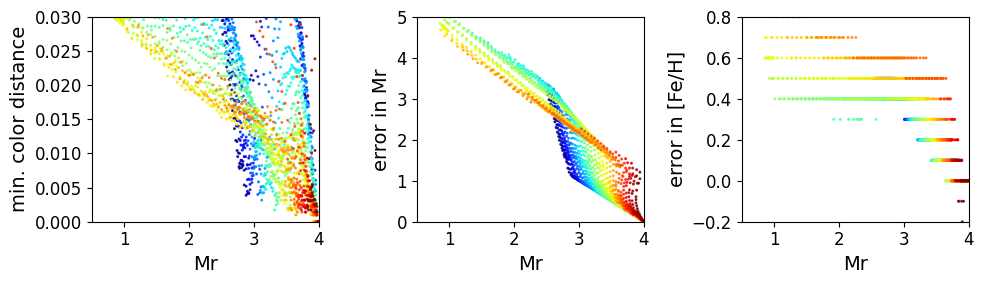

In [121]:
pp.plotRGdegeneracy(LrgDeg)

made plot: xxx.png


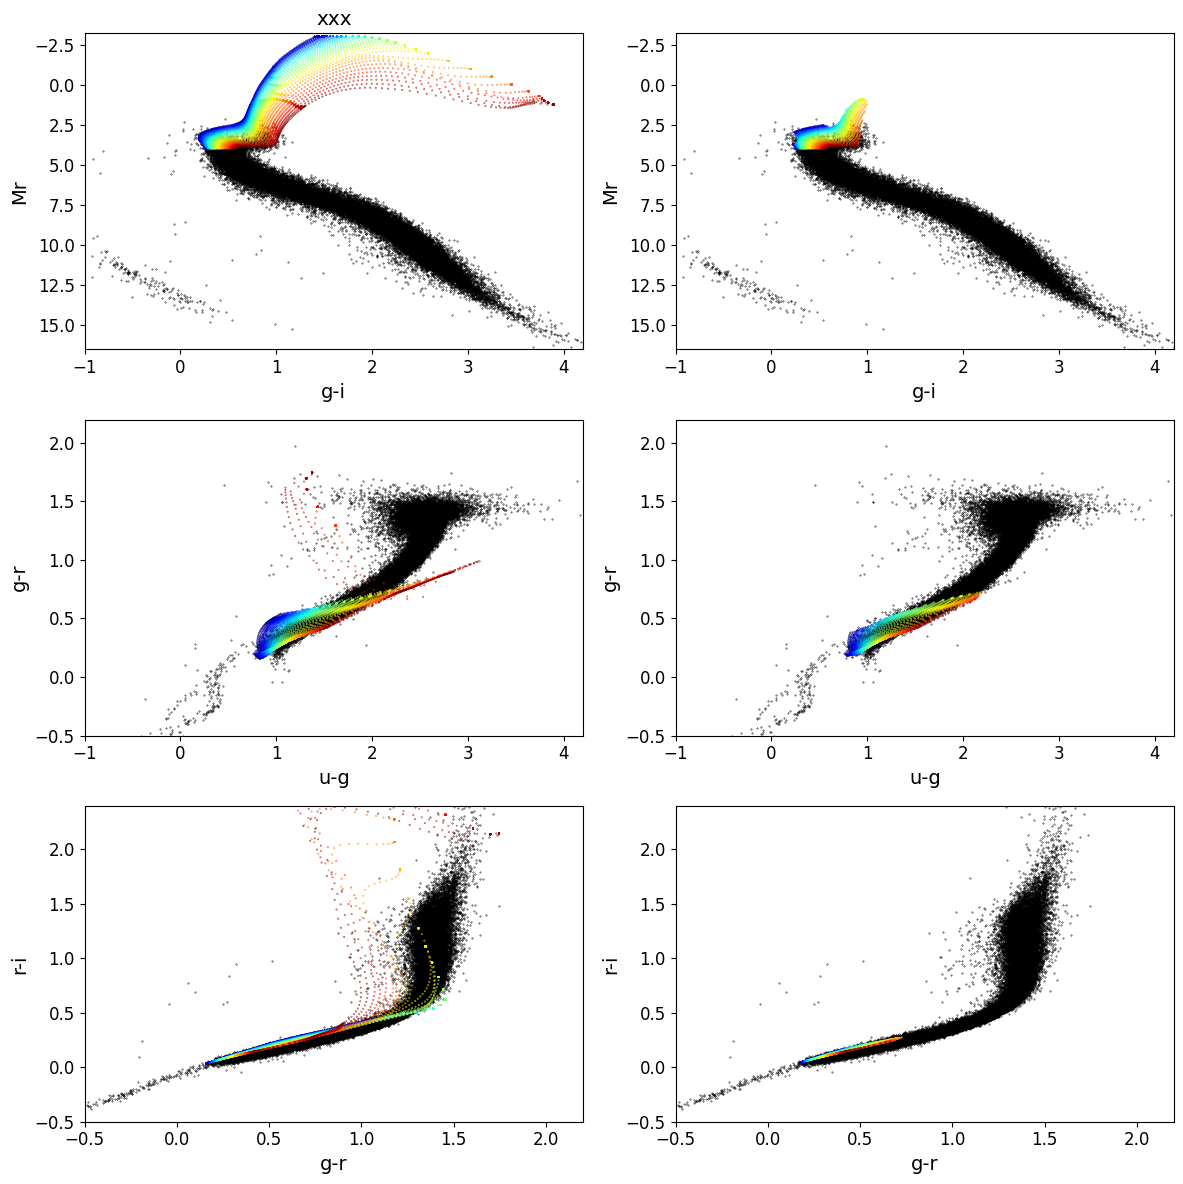

In [122]:
pname = 'xxx.png'
title = 'xxx'
pp.compare2isochrones(s82gaiaPi, Lrg, LrgDeg, alpha1=0.95, alpha2=0.95, title=title, plotname=pname) 

## test Locus10: 
## demonstrate that FeH and Mr are consistent with photoFeH and Mr for g-r<0.5 

In [123]:
Locus10

<Table length=45229>
  tLoc     Mr     FeH      ug      gr      ri      iz           gi        
float64 float64 float64 float64 float64 float64 float64      float64      
------- ------- ------- ------- ------- ------- ------- ------------------
    1.4   -2.98    -2.5   2.002   0.989   0.414    0.23              1.403
   1.41   -2.98    -2.5   2.002   0.989   0.414    0.23              1.403
   1.42   -2.98    -2.5   2.002   0.989   0.414    0.23              1.403
   1.43   -2.98    -2.5   2.002   0.989   0.414    0.23              1.403
   1.44   -2.98    -2.5   2.002   0.989   0.414    0.23              1.403
   1.45   -2.98    -2.5   2.002   0.989   0.414    0.23              1.403
   1.46   -2.98    -2.5   2.002   0.989   0.414    0.23              1.403
   1.47   -2.98    -2.5   2.002   0.989   0.414    0.23              1.403
   1.48   -2.98    -2.5   2.002   0.989   0.414    0.23              1.403
    ...     ...     ...     ...     ...     ...     ...                ...
  15.91   15.91     0.5   2.706   1.719   2.219   1.423 3.9379999999999997
  15.92   15.92     0.5   2.706   1.724   2.221   1.426 3.9450000000000003
  15.93   15.93     0.5   2.706   1.728   2.224   1.429              3.952
  15.94   15.94     0.5   2.706   1.733   2.226   1.432              3.959
  15.95   15.95     0.5   2.706   1.738   2.229   1.436              3.967
  15.96   15.96     0.5   2.706   1.741   2.231   1.439              3.972
  15.97   15.97     0.5   2.706   1.747   2.234   1.442              3.981
  15.98   15.98     0.5   2.706   1.752   2.236   1.445 3.9880000000000004
  15.99   15.99     0.5   2.706   1.757   2.239   1.449 3.9959999999999996

In [124]:
df = Locus10
df['photoFeH'] = lt.photoFeH(df['ug'], df['gr'])  
df['photoMr'] = lt.getMr(df['gi'], df['photoFeH'])
df['dFeH'] = df['FeH'] - df['photoFeH']  
df['dMr'] = df['Mr'] - df['photoMr']  
MS = df[df['Mr']>4]
B = df[(df['gr']>0.2)&(df['gr']<0.6)&(df['Mr']>4.0)]

In [125]:
df = B
print(np.min(df['dFeH']), np.median(df['dFeH']), np.max(df['dFeH'])) 
print(np.min(df['dMr']), np.median(df['dMr']), np.max(df['dMr'])) 

-0.65481903385 -6.243614999856817e-05 0.33868022979999957
-0.1933556657838169 -3.882635376983856e-05 0.22901003179606683


In [126]:
df = MS
print(np.min(df['dFeH']), np.median(df['dFeH']), np.max(df['dFeH'])) 
print(np.min(df['dMr']), np.median(df['dMr']), np.max(df['dMr'])) 

-90.28351882995003 -28.37583420639998 0.35748600903000494
-0.22171864930471408 171.38656582618532 1484.5195250962763


Text(0, 0.5, 'dFeH')

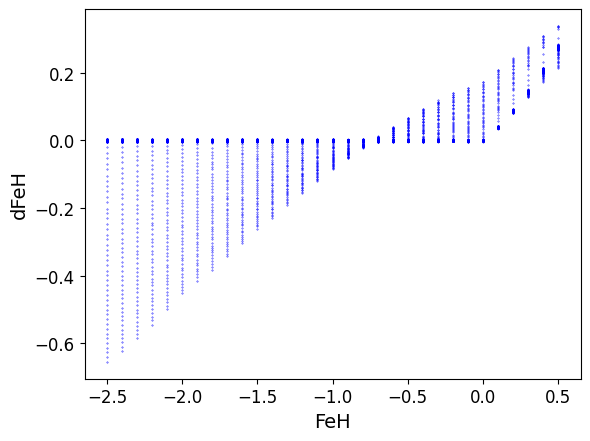

In [127]:
df = B
plt.scatter(df['FeH'], df['dFeH'], c='blue', s=0.1)  
plt.xlabel('FeH')
plt.ylabel('dFeH') 

Text(0, 0.5, 'dMr')

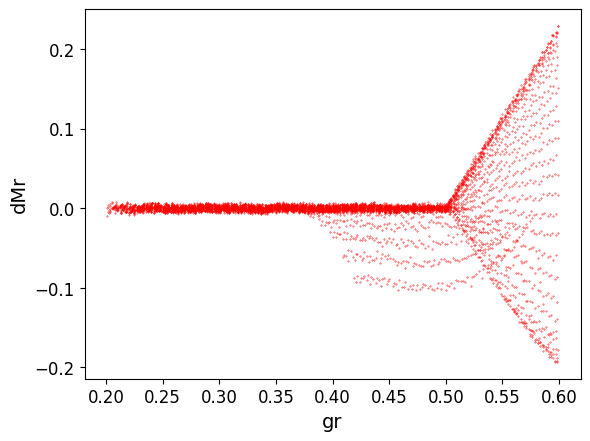

In [128]:
df = B
plt.scatter(df['gr'], df['dMr'], c='red', s=0.1)  
plt.xlabel('gr')
plt.ylabel('dMr') 

In [129]:
Bs = B[B['gr']>0.55]
df = Bs
print(np.min(df['dMr']), np.median(df['dMr']), np.max(df['dMr'])) 

-0.1933556657838169 0.04914139423171804 0.22901003179606683


Text(0, 0.5, 'dFeH')

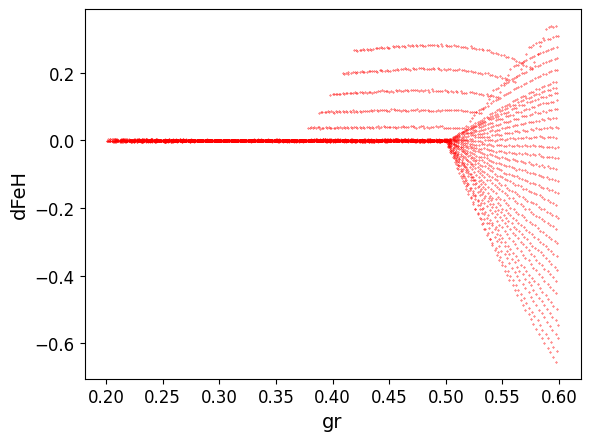

In [130]:
df = B
plt.scatter(df['gr'], df['dFeH'], c='red', s=0.1)  
plt.xlabel('gr')
plt.ylabel('dFeH') 

## compare FeH and Mr to the old Covey et al. locus

In [134]:
df = Lok
df['photoFeH'] = lt.photoFeH(df['ug'], df['gr'])  
df['photoMr'] = lt.getMr(df['gi'], df['photoFeH'])
df['dFeH'] = df['FeH'] - df['photoFeH']  
df['dMr'] = df['Mr'] - df['photoMr']  
B2 = df[(df['gr']>0.2)&(df['gr']<0.6)&(df['Mr']>4.0)]
df = B2
print(np.min(df['dFeH']), np.median(df['dFeH']), np.max(df['dFeH'])) 
print(np.min(df['dMr']), np.median(df['dMr']), np.max(df['dMr'])) 

-1.2026541459551066 -0.2783277744046709 0.5817682446152017
-0.11014832658284313 0.2128212318933418 0.5451185444892035


Text(0, 0.5, 'dMr')

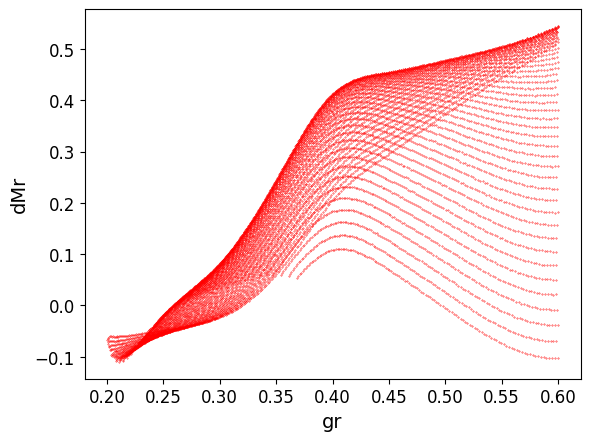

In [135]:
df = B2
plt.scatter(df['gr'], df['dMr'], c='red', s=0.1)  
plt.xlabel('gr')
plt.ylabel('dMr') 

Text(0, 0.5, 'dFeH')

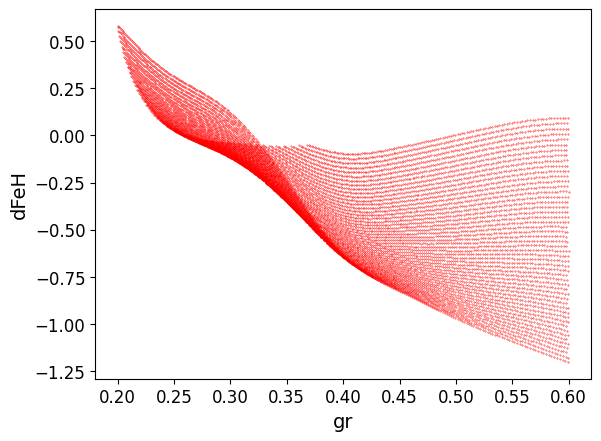

In [136]:
plt.scatter(df['gr'], df['dFeH'], c='red', s=0.1)  
plt.xlabel('gr')
plt.ylabel('dFeH') 